In [1]:
import brainpy.math as bm
import numpy as np
from HDPCCAN_utils import get_tuningMap
from models import HD_cell_L1, PC_cell_L2

import copy

#for plotting
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import cm
from matplotlib.colors import LinearSegmentedColormap
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec

from scipy.interpolate import interp1d
import pycircstat.descriptive as cd

from scipy.ndimage import gaussian_filter
from scipy.signal import find_peaks

import os
import sys
# sys.path.append(os.path.join(os.path.dirname(__file__)))
# sys.path.append('/home/zilong/Desktop/HoneycombSweeps/CircularLinearReg')
from CircularLinearReg.core import (
    cl_corr, 
    circular_mean_resultant_vector_length, 
    cl_regression, 
)

from plotting_utils import (
    plot_circular_histogram, 
    plot_expected_theta_sweep, 
    robust_spline_interpolation, 
    plot_paired_boxplot, 
    plot_circular_histogram_with_values, 
    plot_phase_precession_wrt_nd, 
)

from model_utils import (
    run_model, 
    retrieve_sweep_statistics, 
    retrieve_phase_precession_results, 
    find_periods, 
    restrict_periods_to_field, 
)

import pickle

%matplotlib inline  
%load_ext autoreload 
%autoreload 2

/Users/changminyu/miniconda3/envs/cyu_arm/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# demo
goal_loc = [0.5 * np.pi, 0.5 * np.pi]
total_time = 0.5
dt = 0.01
move_prob = 0.5
drift_factor = 0.0
velocity = 20.0
rotation_speed = np.pi / 50
stick_length = 0.2

v0 = bm.pi / 1000
noise_strength = 0.0
phase_offset = 1.5
theta_hd_modulation = 0.4
theta_gc_modulation = 0.8
top_down_modulation = 4.0

num_hd = 100
tau_hd = 10.0
tau_v_hd = 100.0
mbar_hd = 10.0
a_hd = 0.4
A_hd = 3.0
a_hd_goal = 0.4
A_hd_goal = 3.0
J0_hd = 4.0

top_down = True

num_pc = 50
tau_pc = 10.0
tau_v_pc = 100.0
mbar_pc = 1.0
a_pc = 0.5
A_pc = 5.0
A_td_pc = 5.0
J0_pc = 10.0
g = 1000.0

time_chunk = 50000
device = "cpu"

default_params = {
    "goal_loc": goal_loc,
    "total_time": total_time,
    "dt": dt,
    "move_prob": move_prob,
    "drift_factor": drift_factor,
    "velocity": velocity,
    "rotation_speed": rotation_speed,
    "stick_length": stick_length,
    "v0": v0,
    "noise_strength": noise_strength,
    "phase_offset": phase_offset,
    "theta_hd_modulation": theta_hd_modulation,
    "theta_gc_modulation": theta_gc_modulation,
    "top_down_modulation": top_down_modulation,
    "num_hd": num_hd,
    "tau_hd": tau_hd,
    "tau_v_hd": tau_v_hd,
    "mbar_hd": mbar_hd,
    "a_hd": a_hd,
    "A_hd": A_hd,
    "a_hd_goal": a_hd_goal,
    "A_hd_goal": A_hd_goal,
    "J0_hd": J0_hd,
    "top_down": top_down,
    "num_pc": num_pc,
    "tau_pc": tau_pc,
    "tau_v_pc": tau_v_pc,
    "mbar_pc": mbar_pc,
    "a_pc": a_pc,
    "A_pc": A_pc,
    "A_td_pc": A_td_pc,
    "J0_pc": J0_pc,
    "g": g,
    "time_chunk": time_chunk,
    "device": device
}

In [ ]:
(
    HD_net_with_td, 
    PC_net_with_td,
    animal_centre_all_with_td,
    animal_head_loc_all_with_td,
    hd_all_with_td,
    md_all_with_td,
    gd_all_with_td,
    speed_all_with_td,
    pc_activity_with_td,
    hd_activity_with_td,
    pc_bump_center_with_td,
    hd_bump_center_with_td,
    t_upsampled_with_td,
    theta_phase_with_td,
    theta_rhythm_with_td,
    rotation_phase_with_td,
    rotation_direction_flag_all_with_td,
) = run_model(
    **default_params, 
)

# default_params_no_td = copy.deepcopy(default_params)
# default_params_no_td["top_down"] = False

# (
#     HD_net_no_td, 
#     PC_net_no_td,
#     animal_centre_all_no_td,
#     animal_head_loc_all_no_td,
#     hd_all_no_td,
#     md_all_no_td,
#     gd_all_no_td,
#     speed_all_no_td,
#     pc_activity_no_td,
#     hd_activity_no_td,
#     pc_bump_center_no_td,
#     hd_bump_center_no_td,
#     t_upsampled_no_td,
#     theta_phase_no_td,
#     theta_rhythm_no_td,
#     rotation_phase_no_td,
#     rotation_direction_flag_all_no_td, 
# ) = run_model(
#     **default_params_no_td, 
# )

Start running simulation.
Simnulation progress: 0.0%
Simulation completed.
Start running simulation.
Simnulation progress: 0.0%
Simulation completed.


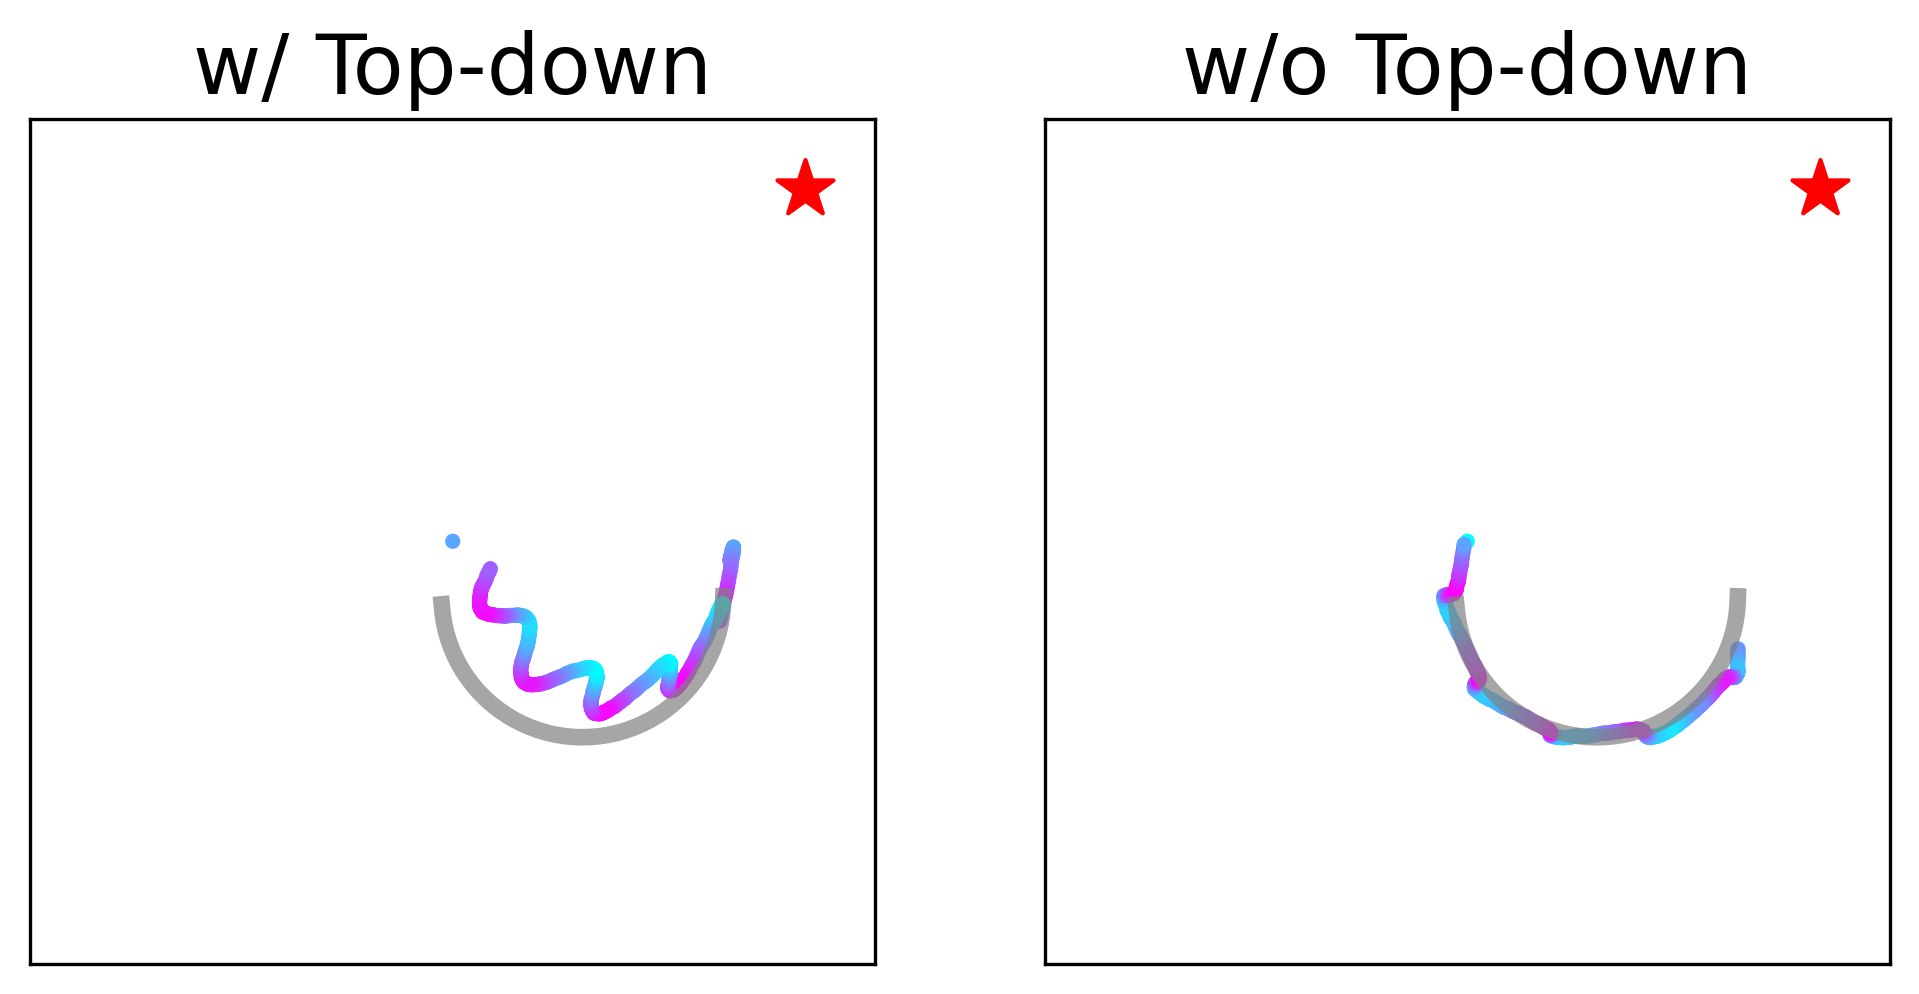

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8, 5), dpi=300)

max_r_grid = np.max(pc_activity_with_td, axis=(1,2)) 

ax[0].plot(
    animal_head_loc_all_with_td[:, 0], 
    animal_head_loc_all_with_td[:, 1], 
    color='grey', 
    linewidth=4.0, 
    label='Traj.', 
    alpha=0.7, 
)
ax[0].scatter(goal_loc[0], goal_loc[1], color='red', marker='*', s=200, label='Goal')

sc = ax[0].scatter(
                pc_bump_center_with_td[:, 0],
                pc_bump_center_with_td[:, 1],
                c=max_r_grid,
                cmap="cool",
                s=7,
        )


#remove the ticks
ax[0].tick_params(axis='both', which='both', length=0)
#remove tick labels
ax[0].set_xticks([])
ax[0].set_yticks([])

ax[0].set_aspect('equal')
ax[0].set_xlim(-0.6*np.pi,0.6*np.pi)
ax[0].set_ylim(-0.6*np.pi,0.6*np.pi)
# ax.set_title('w/o top-down', fontsize=8)
ax[0].set_title('w/ Top-down', fontsize=20)

max_r_grid = np.max(pc_activity_no_td, axis=(1,2)) 

ax[1].plot(
    animal_head_loc_all_no_td[:, 0], 
    animal_head_loc_all_no_td[:, 1], 
    color='grey', 
    linewidth=4.0, 
    label='Traj.', 
    alpha=0.7, 
)
ax[1].scatter(goal_loc[0], goal_loc[1], color='red', marker='*', s=200, label='Goal')

sc = ax[1].scatter(
                pc_bump_center_no_td[:, 0],
                pc_bump_center_no_td[:, 1],
                c=max_r_grid,
                cmap="cool",
                s=7,
        )


#remove the ticks
ax[1].tick_params(axis='both', which='both', length=0)
#remove tick labels
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[1].set_aspect('equal')
ax[1].set_xlim(-0.6*np.pi,0.6*np.pi)
ax[1].set_ylim(-0.6*np.pi,0.6*np.pi)
# ax.set_title('w/o top-down', fontsize=8)
ax[1].set_title('w/o Top-down', fontsize=20)

plt.show()

In [3]:
# full-scale experiment

default_params_full_scale = copy.deepcopy(default_params)
default_params_full_scale["time_chunk"] = 100000
default_params_full_scale["total_time"] = 300
default_params_full_scale["move_prob"] = 0.9
default_params_full_scale["velocity"] = 15

default_params_full_scale["mbar_pc"] = 8.0
default_params_full_scale["theta_gc_modulation"] = 0.5

default_params_full_scale["a_pc"] = 0.7

default_params_full_scale["seed"] = 123

In [6]:
# for i in range(10):
#     default_params_full_scale["seed"] = np.random.randint(0, 10000)

#     (
#         animal_centre_all_with_td,
#         animal_head_loc_all_with_td,
#         hd_all_with_td,
#         md_all_with_td,
#         gd_all_with_td,
#         speed_all_with_td,
#         velocity_all_with_td, 
#         pc_activity_with_td,
#         hd_activity_with_td,
#         pc_bump_center_with_td,
#         hd_bump_center_with_td,
#         t_upsampled_with_td,
#         theta_phase_with_td,
#         theta_rhythm_with_td,
#         rotation_phase_with_td,
#         rotation_direction_flag_all_with_td,
#     ) = run_model(
#         **default_params_full_scale, 
#     )
    
#     results = (
#         animal_centre_all_with_td,
#         animal_head_loc_all_with_td,
#         hd_all_with_td,
#         md_all_with_td,
#         gd_all_with_td,
#         speed_all_with_td,
#         velocity_all_with_td, 
#         pc_activity_with_td,
#         hd_activity_with_td,
#         pc_bump_center_with_td,
#         hd_bump_center_with_td,
#         t_upsampled_with_td,
#         theta_phase_with_td,
#         theta_rhythm_with_td,
#         rotation_phase_with_td,
#         rotation_direction_flag_all_with_td,
#     )
    
#     pickle.dump((default_params_full_scale["seed"], results), open(f"logs/results_with_td_seed_{i}.pickle", "wb"))
    
#     bm.clear_buffer_memory(default_params_full_scale["device"])

default_params_no_td_full_scale = copy.deepcopy(default_params_full_scale)
default_params_no_td_full_scale["top_down"] = False
# default_params_no_td_full_scale["animal_head_loc_all"] = animal_head_loc_all_with_td
# default_params_no_td_full_scale["md_all"] = md_all_with_td
# default_params_no_td_full_scale["speed_all"] = speed_all_with_td
# default_params_no_td_full_scale["gd_all"] = gd_all_with_td

(
    animal_centre_all_no_td,
    animal_head_loc_all_no_td,
    hd_all_no_td,
    md_all_no_td,
    gd_all_no_td,
    speed_all_no_td,
    velocity_all_no_td,
    pc_activity_no_td,
    hd_activity_no_td,
    pc_bump_center_no_td,
    hd_bump_center_no_td,
    t_upsampled_no_td,
    theta_phase_no_td,
    theta_rhythm_no_td,
    rotation_phase_no_td,
    rotation_direction_flag_all_no_td,
) = run_model(
    **default_params_no_td_full_scale, 
)

Start running simulation.
Simnulation progress: 0.0%
Simnulation progress: 33.3%
Simnulation progress: 66.7%
Simulation completed.


In [13]:
all_processed_results = {
    "sd_vs_gd": [],
    "sd_vs_md": [],
    "sd_vs_hd": [],
    "iol_vs_gd": [],
    "iod_vs_gd": [],
    "iod_vs_md": [],
    "angle_zero_phase": [],
    "sweep_length": []
}

for seed in range(10):
    logdir = f"logs/results_with_td_seed_{seed}.pickle"
    with open(logdir, "rb") as f:
        results = pickle.load(f)[1]
    f.close()
    # Process results
    (
        sd_vs_gd, 
        sd_vs_md, 
        sd_vs_hd, 
        iod_vs_gd, 
        iol_vs_gd, 
        angle_zero_phase, 
        iod_vs_md, 
        sweep_length
    ) = retrieve_sweep_statistics(results, start_ind=15, end_ind=65)
    
    all_processed_results["sd_vs_gd"].append(sd_vs_gd)
    all_processed_results["sd_vs_md"].append(sd_vs_md)
    all_processed_results["sd_vs_hd"].append(sd_vs_hd)
    all_processed_results["iol_vs_gd"].append(iol_vs_gd)
    all_processed_results["iod_vs_gd"].append(iod_vs_gd)
    all_processed_results["iod_vs_md"].append(iod_vs_md)
    all_processed_results["angle_zero_phase"].append(angle_zero_phase)
    all_processed_results["sweep_length"].append(sweep_length)

In [14]:
sd_vs_gd_mrl_all_seed = np.array([
    circular_mean_resultant_vector_length(all_processed_results["sd_vs_gd"][i]) for i in range(10)
])
sd_vs_md_mrl_all_seed = np.array([
    circular_mean_resultant_vector_length(all_processed_results["sd_vs_md"][i]) for i in range(10)
])
sd_vs_hd_mrl_all_seed = np.array([
    circular_mean_resultant_vector_length(all_processed_results["sd_vs_hd"][i]) for i in range(10)
])

8.583592479062847e-29
0.00010207581242100841


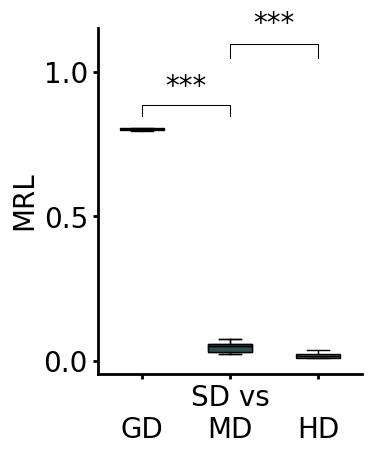

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))

plot_paired_boxplot(
    np.array(sd_vs_gd_mrl_all_seed), 
    np.array(sd_vs_hd_mrl_all_seed),
    pos1=1, 
    pos2=2, 
    labels=["#333333", "#2F4F4F"], 
    plot_paired_lines=False, 
    ax=ax, 
    fontsize=20, 
)

plot_paired_boxplot(
    np.array(sd_vs_hd_mrl_all_seed), 
    np.array(sd_vs_md_mrl_all_seed),
    pos1=2, 
    pos2=3, 
    labels=["", ""], 
    plot_paired_lines=False, 
    ax=ax, 
    ylabel="MRL",
    y_max=1.0, 
    fontsize=20, 
    colors=["#2F4F4F", "#8B4513"]
)

ax.set_yticks([0.0, 0.5, 1.0])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels([
    " \nGD", 
    "SD vs\nMD",
    " \nHD", 
], fontsize=20)

fig.savefig("figures/PaperFig/mrl_comparison.pdf", bbox_inches='tight', dpi=300, transparent=True)
plt.show()

In [29]:
# Example usage:

cellindex = [25, 25]

decreasing_periods, increasing_periods = find_periods(animal_head_loc_all_with_td, goal_loc, threshold=300)

start_idx = 22
end_idx = 28

Dist2G_decreasing = []
SpikePhase_decreasing = []

Dist2G_increasing = []
SpikePhase_increasing = []

cellindex_y = np.random.randint(12, 38)

for cellindex_x in range(start_idx, end_idx + 1, 1):
    print(f"Processing cell index: ({cellindex_x}, {cellindex_y})")
    for cellindex_y in range(start_idx, end_idx + 1, 1):
        
        Dist2G = []
        SpikePhase = []
        r = pc_activity_with_td[:, cellindex[0], cellindex[1]]
        
        spikes = np.random.poisson(r/10)  # Convert to spikes per second
        
        for start, end in decreasing_periods:
            for i in range(start, end):
                #get the distance to goal_loc
                dist_i = np.linalg.norm(animal_head_loc_all_with_td[i] - goal_loc)
                #get the phase at current time step i
                phase_i = theta_phase_with_td[i]*np.pi*2

                spike = spikes[i]
                if spike > 0:
                    #save dist_i and phase_i
                    Dist2G.append(dist_i)
                    SpikePhase.append(phase_i)

        Dist2G = np.asarray(Dist2G)
        #normalize Dist2G to [0, 1]
        # Dist2G = (Dist2G - Dist2G.min()) / (Dist2G.max() - Dist2G.min())
        SpikePhase = np.asarray(SpikePhase)       
        
        Dist2G_decreasing.extend(Dist2G)
        SpikePhase_decreasing.extend(SpikePhase)
        
        #------------------------------------------------------------------------
        #now get spikephase during increasing_periods_field
        Dist2G = []
        SpikePhase = []
        
        for start, end in increasing_periods:
            for i in range(start, end):
                #get the distance to goal_loc
                dist_i = np.linalg.norm(animal_head_loc_all_with_td[i] - goal_loc)
                #get the phase at current time step i
                phase_i = theta_phase_with_td[i]*np.pi*2
                spike = spikes[i]
                if spike > 0:
                    #save dist_i and phase_i
                    Dist2G.append(dist_i)
                    SpikePhase.append(phase_i)

        Dist2G = np.asarray(Dist2G)
        #normalize Dist2G to [0, 1]
        # Dist2G = (Dist2G - Dist2G.min()) / (Dist2G.max() - Dist2G.min())
        SpikePhase = np.asarray(SpikePhase)
        
        Dist2G_increasing.extend(Dist2G)
        SpikePhase_increasing.extend(SpikePhase)

Processing cell index: (22, 22)
Processing cell index: (23, 28)
Processing cell index: (24, 28)
Processing cell index: (25, 28)
Processing cell index: (26, 28)
Processing cell index: (27, 28)
Processing cell index: (28, 28)


/var/folders/6b/58_qt7d91c96pg2b8nn3nd2m0000gn/T/ipykernel_25406/2077859513.py:149: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'], fontsize=fontsize)


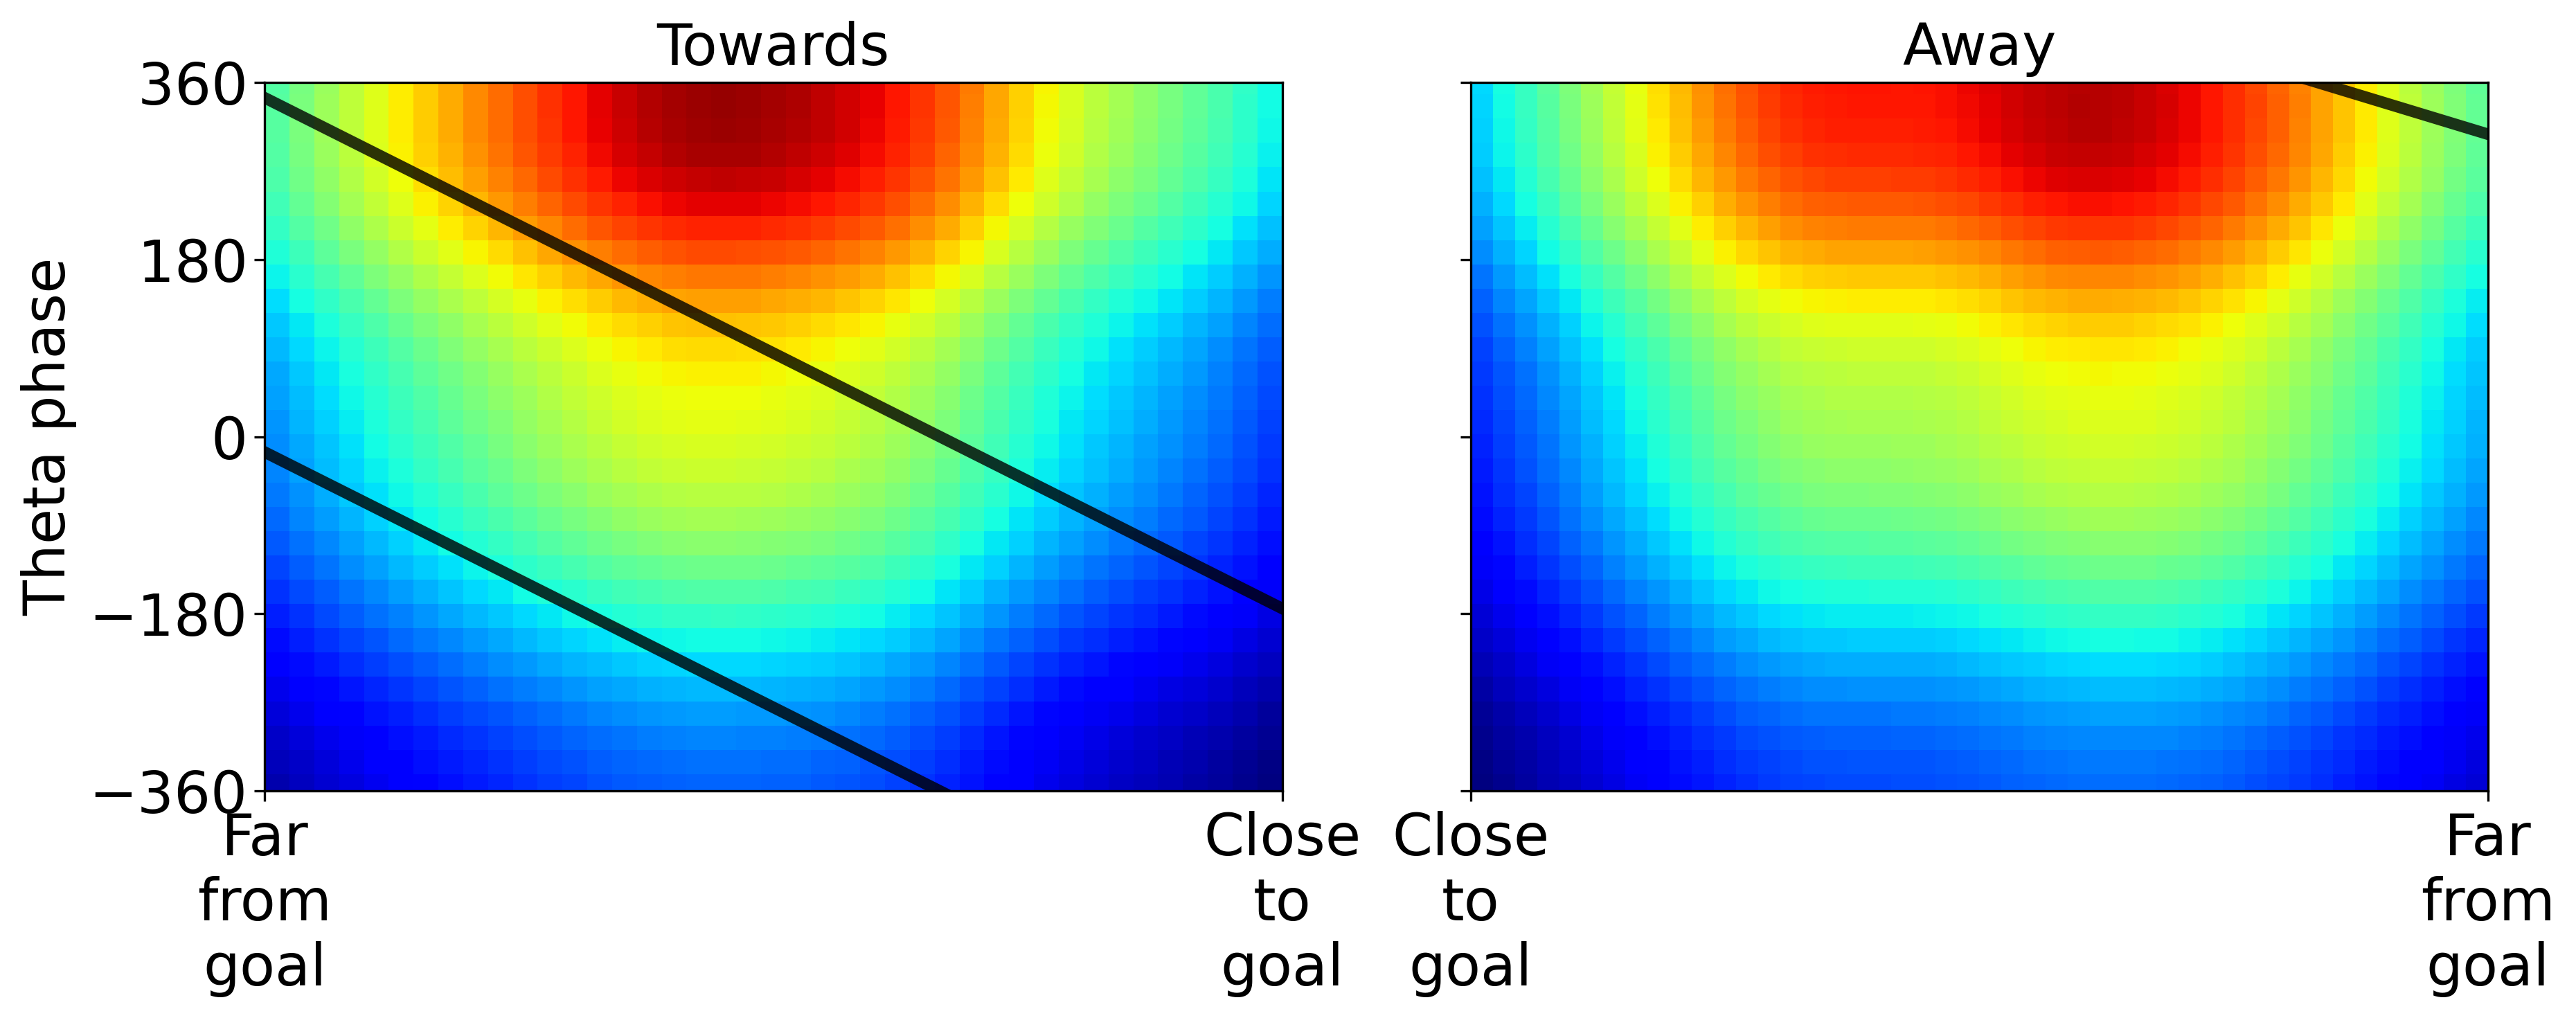

In [30]:
#----------------------- ------------------------------------- --------------------------------- ------------------------------------      
n_bins = 120

fontsize = 20

SpikePhase_decreasing = np.asarray(SpikePhase_decreasing)
SpikePhase_increasing = np.asarray(SpikePhase_increasing)
Dist2G_decreasing = np.asarray(Dist2G_decreasing)
Dist2G_increasing = np.asarray(Dist2G_increasing)

phi_decreasing, slope_decreasing, R_decreasing = cl_regression(
    Dist2G_decreasing, 
    SpikePhase_decreasing, 
    min_slope=-10, 
    max_slope=10, 
)

phi_increasing, slope_increasing, R_increasing = cl_regression(
    Dist2G_increasing, 
    SpikePhase_increasing, 
    min_slope=-10, 
    max_slope=10, 
)


fig = plt.figure(figsize=(12.5, 5), dpi=300)
gs = gridspec.GridSpec(1, 2)

ax = plt.subplot(gs[0])

# Wrap phase by duplicating with +2π to handle circularity
SpikePhase_wrapped = np.concatenate([SpikePhase_decreasing, SpikePhase_decreasing + 2 * np.pi, SpikePhase_decreasing + 4*np.pi]) 
Dist2G_wrapped = np.concatenate([Dist2G_decreasing, Dist2G_decreasing, Dist2G_decreasing])
# Compute 2D histogram
heatmap, xedges, yedges = np.histogram2d(Dist2G_wrapped, SpikePhase_wrapped, bins=[n_bins, n_bins])
# Smooth with Gaussian filter
heatmap_smooth = gaussian_filter(heatmap, sigma=4)

sum_heatmap = np.sum(heatmap_smooth, axis=1)
valid_x_indices = sum_heatmap > 0.5 * np.max(sum_heatmap)
# Apply column filter
heatmap_smooth_4_plot = heatmap_smooth[valid_x_indices, :]

# Adjust xedges and X accordingly
xedges_filtered = xedges[:-1][valid_x_indices]  # remove last bin edge, select valid
xedges_filtered = np.append(xedges_filtered, xedges_filtered[-1] + np.diff(xedges).mean())  # match dimension

# Create matching meshgrid
X, Y = np.meshgrid(xedges_filtered, yedges)

# Plot
pcm = ax.pcolormesh(X, Y, heatmap_smooth_4_plot.T, shading='auto', cmap='jet')

#!!!! flip x axis with small values on the right and large values on the left
# Flip the x-axis
ax.invert_xaxis()

width = xedges_filtered.max() - xedges_filtered.min()
xmin = xedges_filtered.min() + 0.0 * width
xmax = xedges_filtered.max() - 0.0 * width
# ax.set_xlim(xmin, xmax)
ax.set_xticks([xmin, xmax])
ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'], fontsize=fontsize)

ax.set_ylabel('Theta phase', fontsize=fontsize)
# #activity colorba
ax.set_ylim(np.pi, 5*np.pi) #start from np.pi since we want to make MUA trough as 0 degree, previous is 180 degree
ax.set_yticks([np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi])
ax.set_yticklabels([r'$-360$', r'$-180$', r'$0$', r'$180$', r'$360$'], fontsize=fontsize)   
ax.set_title('Towards', fontsize=fontsize)
ax.tick_params(axis='both', which='major', labelsize=fontsize)

# Create line in data coordinates, then map to bin coordinates
x_line = np.linspace(xedges_filtered.min(), xedges_filtered.max(), 100)  # bin indices
x_data = np.linspace(Dist2G_decreasing.min(), Dist2G_decreasing.max(), 100)  # corresponding data values

y_fitted = np.mod(slope_decreasing * x_line - 0, 8 * np.pi)
# y_fitted_degrees = np.deg2rad(np.degrees(y_fitted))
# y_fitted_wrapped = np.deg2rad(np.mod(y_fitted_degrees + 180, 360) - 180) + 2 * np.pi

# Map to bin indices
# y_bin_line = (y_fitted_wrapped + 180) / 360 * n_y_bins

ax.plot(x_line[::-1], y_fitted, 'k', linewidth=4, alpha=0.8)
ax.plot(x_line[::-1], y_fitted - 2 * np.pi, 'k', linewidth=4, alpha=0.8)
ax.plot(x_line[::-1], y_fitted - 4 * np.pi, 'k', linewidth=4, alpha=0.8)


#------------------------------- ------------------------------------- --------------------------------- ------------------------------------      
fontsize = 20
ax = plt.subplot(gs[1])

# Wrap phase by duplicating with +2π to handle circularity
SpikePhase_wrapped = np.concatenate([SpikePhase_increasing, SpikePhase_increasing + 2 * np.pi, SpikePhase_increasing + 4*np.pi]) 
Dist2G_wrapped = np.concatenate([Dist2G_increasing, Dist2G_increasing, Dist2G_increasing])
# Compute 2D histogram
heatmap, xedges, yedges = np.histogram2d(Dist2G_wrapped, SpikePhase_wrapped, bins=[n_bins, n_bins])
# Smooth with Gaussian filter
heatmap_smooth = gaussian_filter(heatmap, sigma=4)
sum_heatmap = np.sum(heatmap_smooth, axis=1)
valid_x_indices = sum_heatmap > 0.5 * np.max(sum_heatmap)
# Apply column filter
heatmap_smooth_4_plot = heatmap_smooth[valid_x_indices, :]

# Adjust xedges and X accordingly
xedges_filtered = xedges[:-1][valid_x_indices]  # remove last bin edge, select valid
xedges_filtered = np.append(xedges_filtered, xedges_filtered[-1] + np.diff(xedges).mean())  # match dimension

# Create matching meshgrid
X, Y = np.meshgrid(xedges_filtered, yedges)

# Plot
pcm = ax.pcolormesh(X, Y, heatmap_smooth_4_plot.T, shading='auto', cmap='jet')

width = xedges_filtered.max() - xedges_filtered.min()
xmin = xedges_filtered.min() + 0.0 * width
xmax = xedges_filtered.max() - 0.0 * width
# ax.set_xlim(xmin, xmax)
# ax[0].set_xlabel('Head direction')
# ax.set_xlabel('Dist2Goal', fontsize=10)
#show y axis, ticks labels on the right
# ax.yaxis.tick_right()
# ax.yaxis.set_label_position("right")
    
# ax.set_ylabel('Theta phase', fontsize=fontsize)
ax.set_ylim(np.pi, 5*np.pi)  #start from np.pi since we want to make MUA trough as 0 degree, previous is 180 degree
ax.set_yticks([np.pi, 2*np.pi, 3*np.pi, 4*np.pi, 5*np.pi])
# ax.set_yticklabels([r'$-360$', r'$-180$', r'$0$', r'$180$', r'$360$'])   
ax.set_yticklabels(["", "", "", "", ""])
ax.set_title('Away', fontsize=fontsize)
#tickfontsize as 6
ax.tick_params(axis='both', which='major', labelsize=8)

# Create line in data coordinates, then map to bin coordinates
x_line = np.linspace(xedges_filtered.min(), xedges_filtered.max(), 100)  # bin indices
x_data = np.linspace(Dist2G_increasing.min(), Dist2G_increasing.max(), 100)  # corresponding data values

y_fitted = np.mod(slope_increasing * x_line + 0, 8 * np.pi)
# y_fitted_degrees = np.deg2rad(np.degrees(y_fitted))
# y_fitted_wrapped = np.deg2rad(np.mod(y_fitted_degrees + 180, 360) - 180) + 2 * np.pi

# Map to bin indices
# y_bin_line = (y_fitted_wrapped + 180) / 360 * n_y_bins

ax.plot(x_line, y_fitted, 'k', linewidth=4, alpha=0.8)
ax.plot(x_line, y_fitted + 2 * np.pi, 'k', linewidth=4, alpha=0.8)
ax.plot(x_line, y_fitted + 4 * np.pi, 'k', linewidth=4, alpha=0.8)

ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'], fontsize=fontsize)
ax.set_xticks([xmin, xmax])
####################################################################################################


plt.tight_layout()

# plt.savefig('figures/PaperFig/phaseprecession2goal.pdf', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

Processing cell index: (22, 22)
Processing cell index: (22, 23)
Processing cell index: (22, 24)
Processing cell index: (22, 25)
Processing cell index: (22, 26)
Processing cell index: (22, 27)
Processing cell index: (22, 28)
Processing cell index: (23, 22)
Processing cell index: (23, 23)
Processing cell index: (23, 24)
Processing cell index: (23, 25)
Processing cell index: (23, 26)
Processing cell index: (23, 27)
Processing cell index: (23, 28)
Processing cell index: (24, 22)
Processing cell index: (24, 23)
Processing cell index: (24, 24)
Processing cell index: (24, 25)
Processing cell index: (24, 26)
Processing cell index: (24, 27)
Processing cell index: (24, 28)
Processing cell index: (25, 22)
Processing cell index: (25, 23)
Processing cell index: (25, 24)
Processing cell index: (25, 25)
Processing cell index: (25, 26)
Processing cell index: (25, 27)
Processing cell index: (25, 28)
Processing cell index: (26, 22)
Processing cell index: (26, 23)
Processing cell index: (26, 24)
Processi

/Users/changminyu/Desktop/research/codes/neuroscience/HoneycombSweeps/plotting_utils.py:905: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'], fontsize=fontsize)


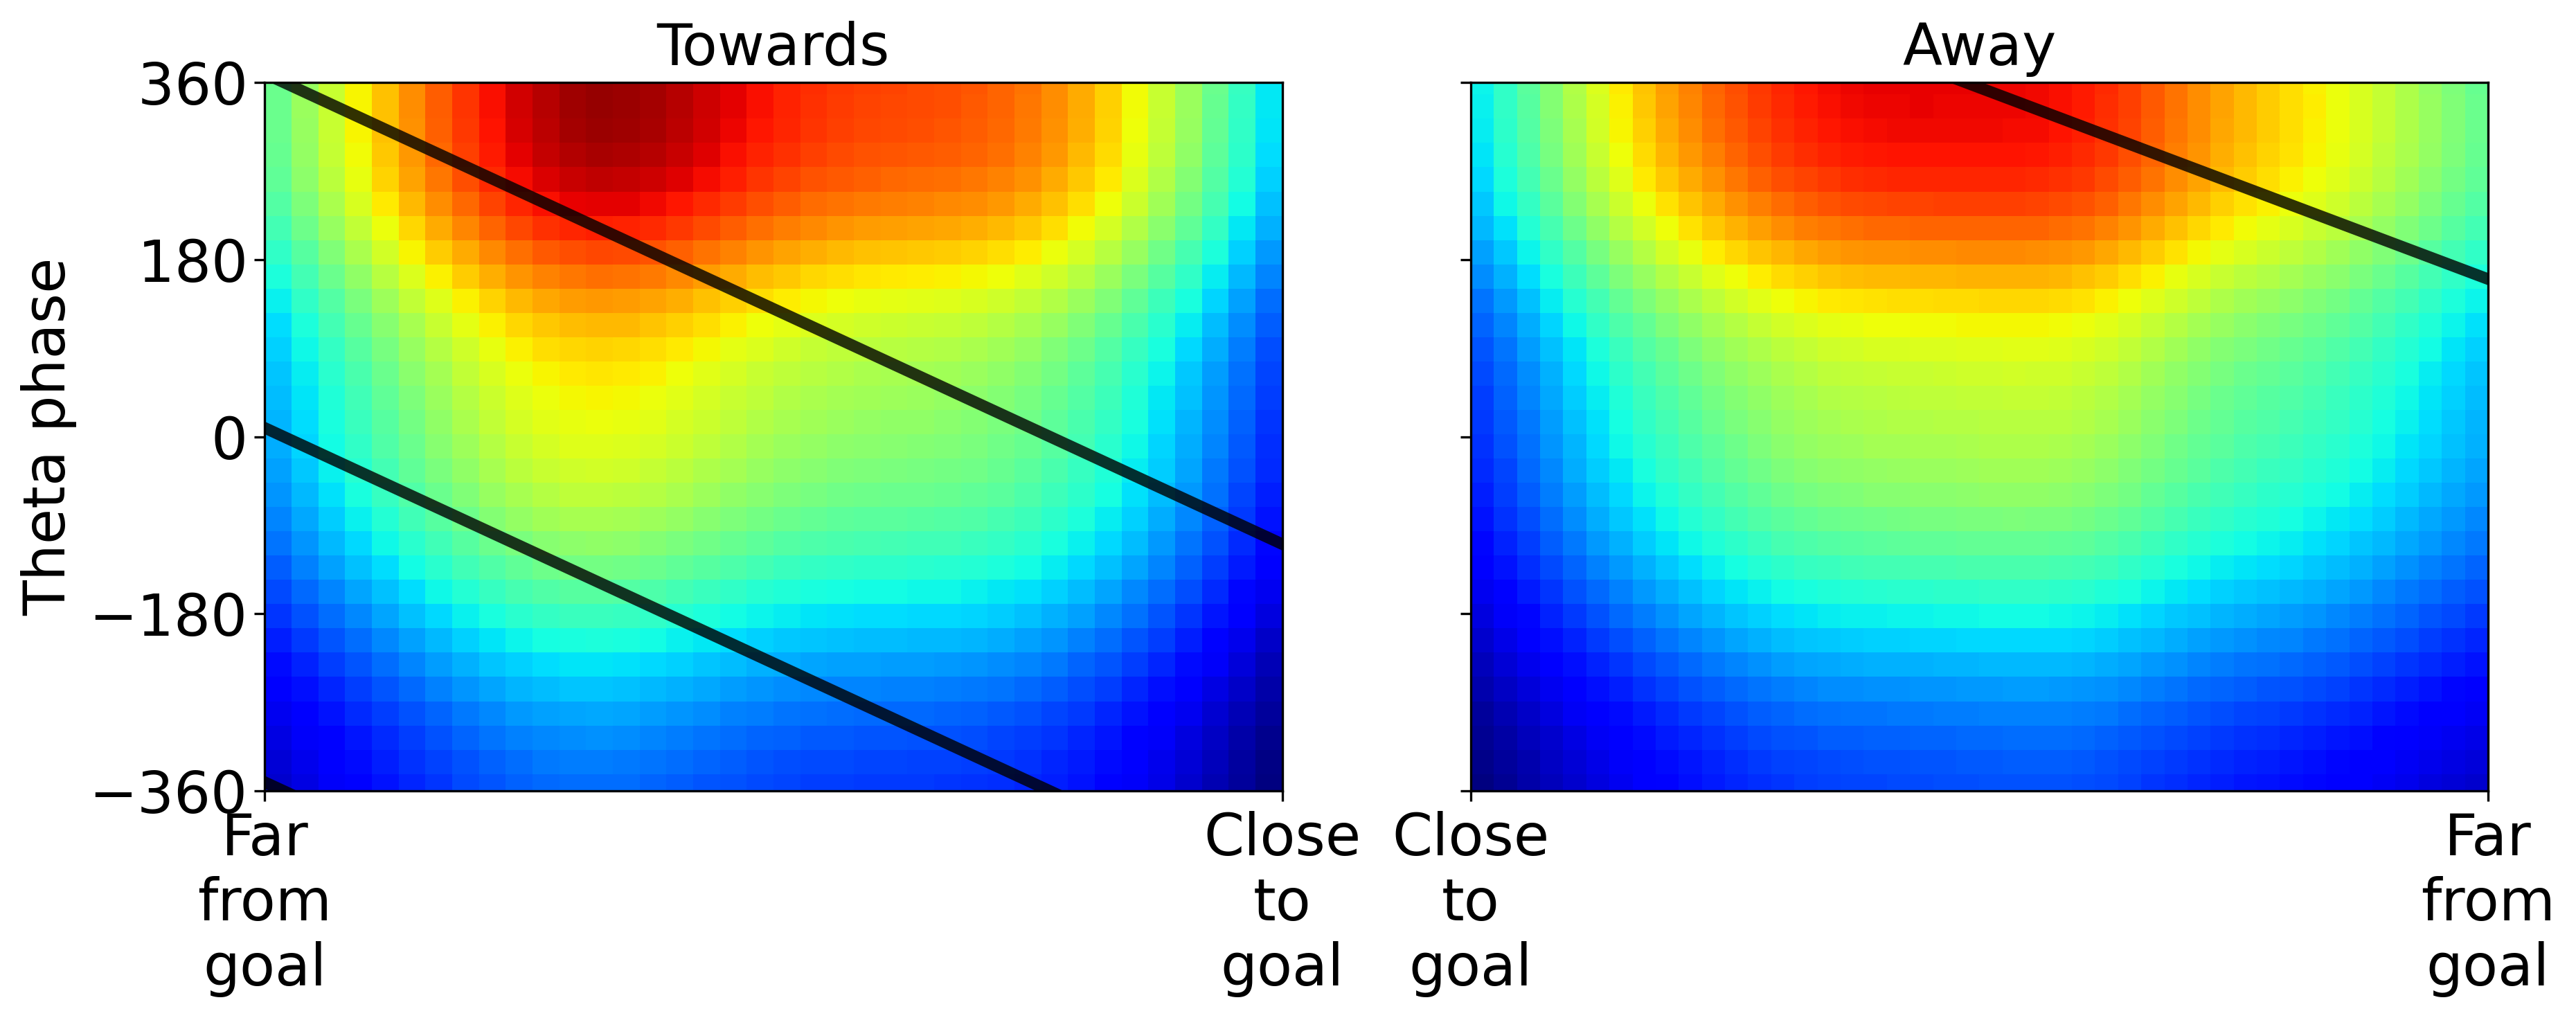

Processing cell index: (22, 22)
Processing cell index: (22, 23)
Processing cell index: (22, 24)
Processing cell index: (22, 25)
Processing cell index: (22, 26)
Processing cell index: (22, 27)
Processing cell index: (22, 28)
Processing cell index: (23, 22)
Processing cell index: (23, 23)
Processing cell index: (23, 24)
Processing cell index: (23, 25)
Processing cell index: (23, 26)
Processing cell index: (23, 27)
Processing cell index: (23, 28)
Processing cell index: (24, 22)
Processing cell index: (24, 23)
Processing cell index: (24, 24)
Processing cell index: (24, 25)
Processing cell index: (24, 26)
Processing cell index: (24, 27)
Processing cell index: (24, 28)
Processing cell index: (25, 22)
Processing cell index: (25, 23)
Processing cell index: (25, 24)
Processing cell index: (25, 25)
Processing cell index: (25, 26)
Processing cell index: (25, 27)
Processing cell index: (25, 28)
Processing cell index: (26, 22)
Processing cell index: (26, 23)
Processing cell index: (26, 24)
Processi

/Users/changminyu/Desktop/research/codes/neuroscience/HoneycombSweeps/plotting_utils.py:905: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Close\nto\ngoal', 'Far\nfrom\ngoal'], fontsize=fontsize)


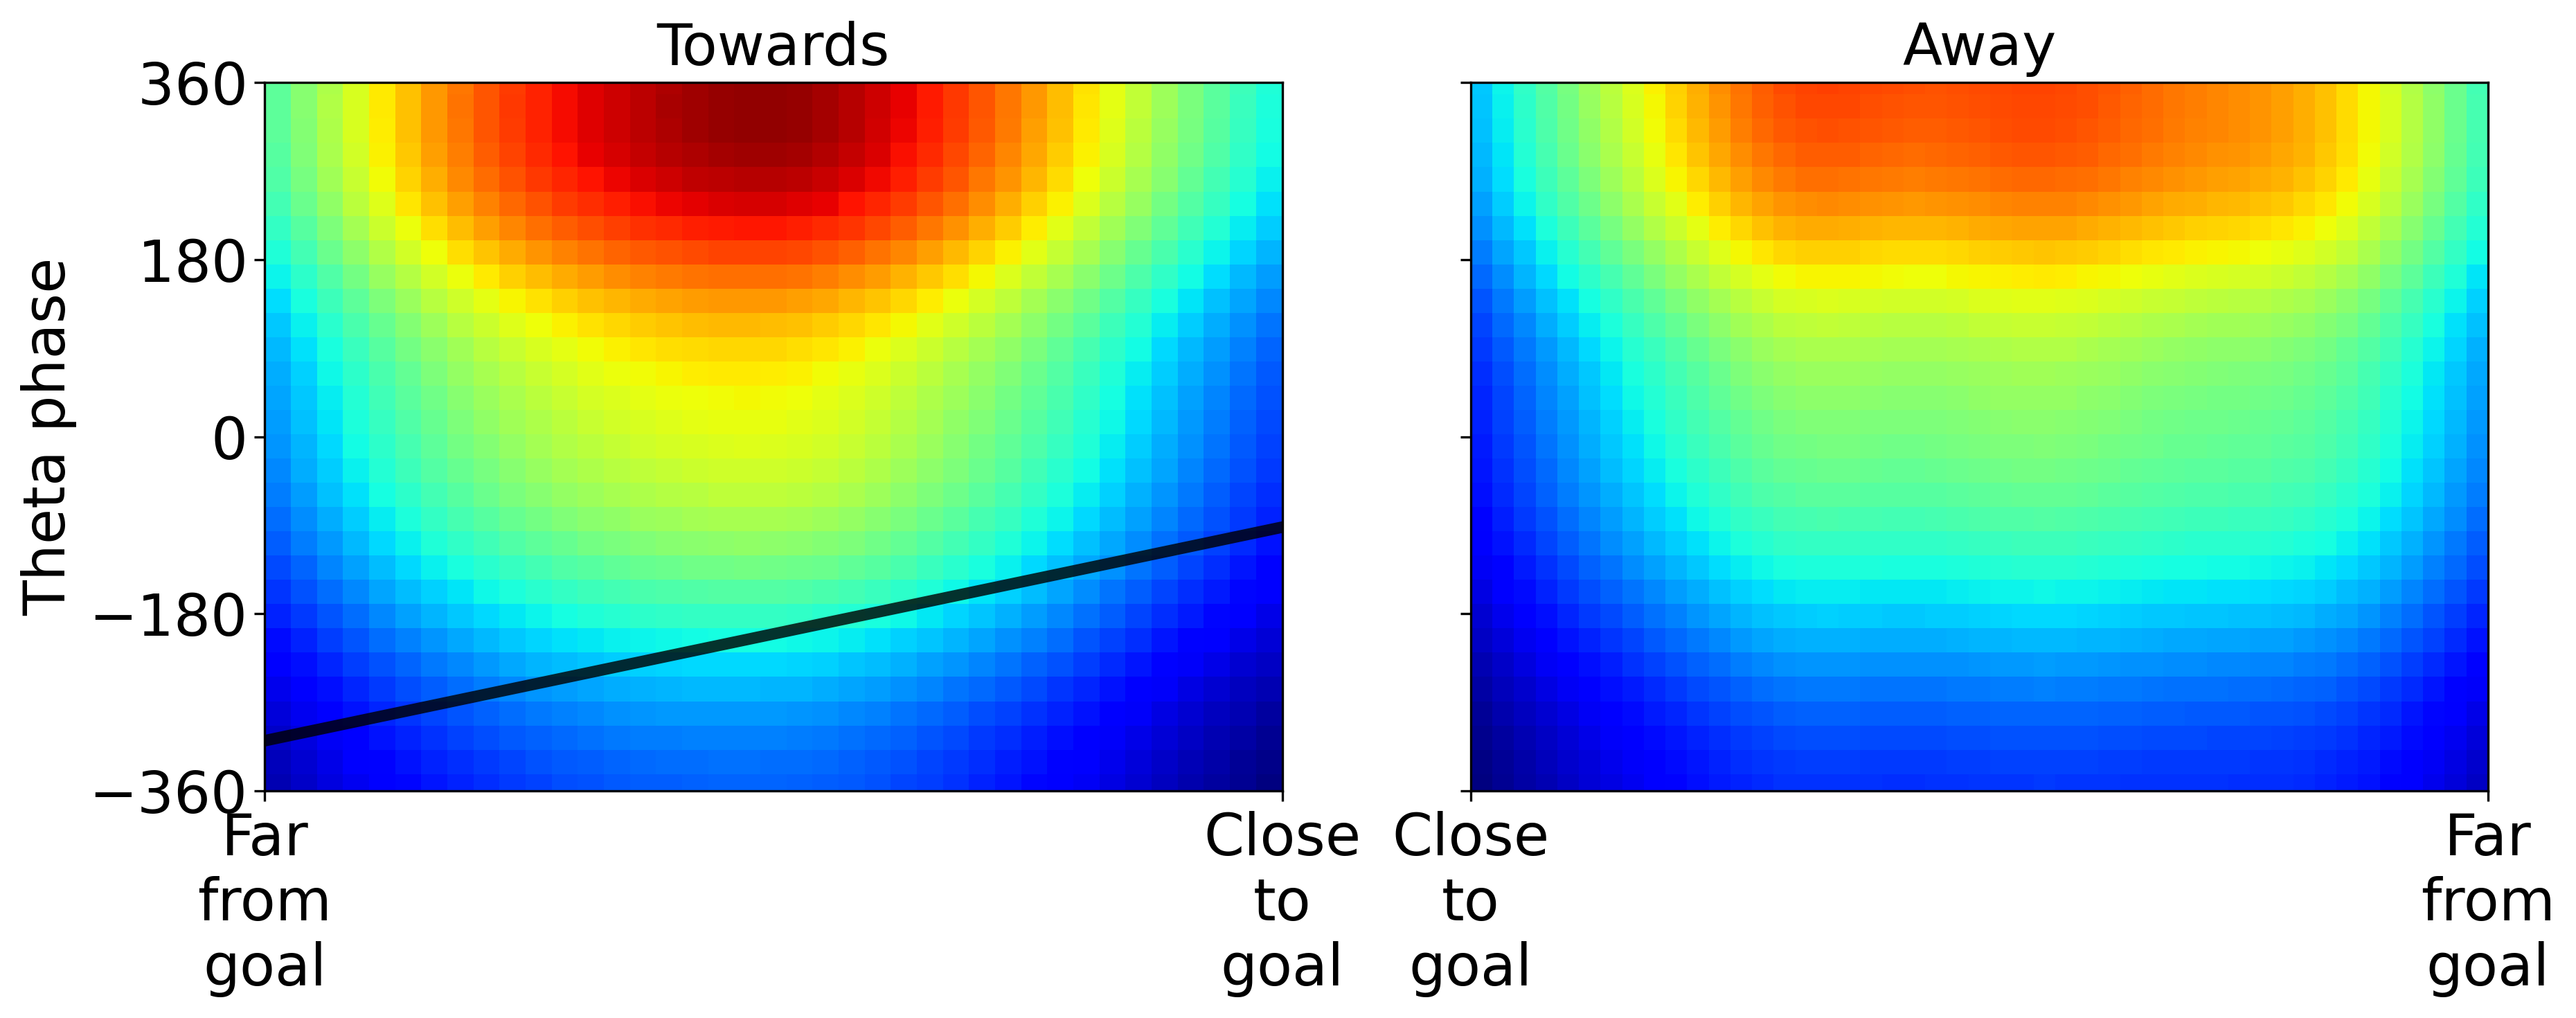

Processing cell index: (22, 22)


KeyboardInterrupt: 

In [25]:
for seed in range(10):
    logdir = f"logs/results_with_td_seed_{seed}.pickle"
    with open(logdir, "rb") as f:
        results = pickle.load(f)[1]
    f.close()
    # Process results
    (
        SpikePhase_decreasing, 
        SpikePhase_increasing, 
        Dist2G_decreasing, 
        Dist2G_increasing, 
        phi_decreasing, 
        slope_decreasing, 
        R_decreasing, 
        phi_increasing, 
        slope_increasing, 
        R_increasing, 
    ) = retrieve_phase_precession_results(results, start_ind=22, end_ind=28)
    
    plot_phase_precession_wrt_nd(
        SpikePhase_decreasing, 
        SpikePhase_increasing, 
        Dist2G_decreasing, 
        Dist2G_increasing, 
        phi_decreasing, 
        slope_decreasing, 
        R_decreasing, 
        phi_increasing, 
        slope_increasing, 
        R_increasing, 
        n_bins=120, 
        fontsize=20
    )

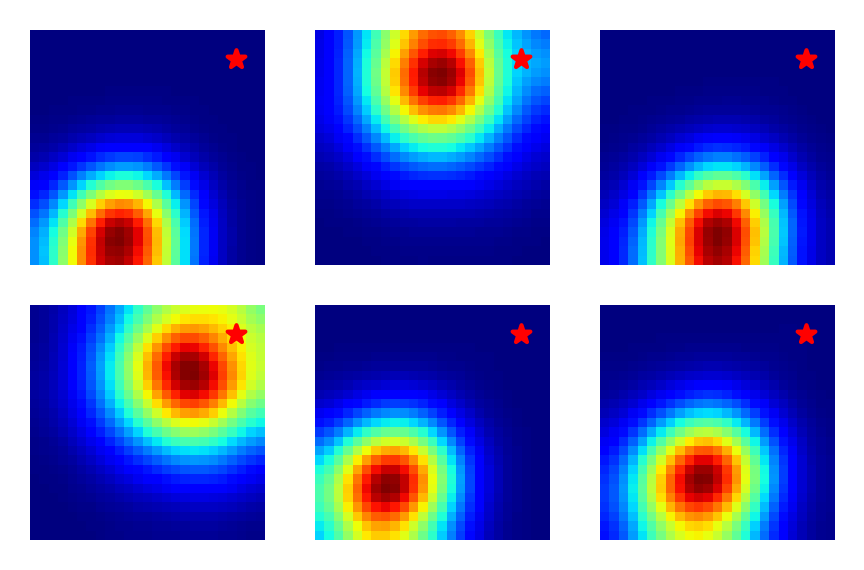

In [8]:

#plot all the firing rates in a single merged image

num = 50

fig, axs = plt.subplots(2, 3, figsize=(3,2), dpi=300)

dim = num//2
Position_norm = (animal_head_loc_all_with_td - animal_head_loc_all_with_td.min() - 1e-5)/(animal_head_loc_all_with_td.max() - animal_head_loc_all_with_td.min())
#mark the goal location
goal_x = (goal_loc[0]- animal_head_loc_all_with_td.min())/(animal_head_loc_all_with_td.max() - animal_head_loc_all_with_td.min())*dim
goal_y = (goal_loc[1]- animal_head_loc_all_with_td.min())/(animal_head_loc_all_with_td.max() - animal_head_loc_all_with_td.min())*dim

for i in range(6):
    cellindex_x = np.random.randint(12, 38)
    cellindex_y = np.random.randint(12, 38)
    map = get_tuningMap(pc_activity_with_td, 
                        Position_norm, 
                        cellindex_x=cellindex_x,
                        cellindex_y=cellindex_y,
                        filter= True,
                        samples_per_sec=1000,
                        dim=dim)
    
    #5 row and 2 cols
    ax = axs[i // 3, i % 3]

    ax.scatter(goal_x, goal_y, color='red', marker='*', s=20)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')  
    ax.imshow(map, cmap='jet', origin='lower')
    
    ax.grid(False)

plt.tight_layout()
# plt.savefig('figures/PaperFig/Example_place_maps.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.show()


In [5]:
import seaborn as sns
from scipy.signal import find_peaks
from matplotlib.colors import LinearSegmentedColormap

def create_custom_trajectory_cmap(target_color):
    """
    Create a colormap that transitions from white to the target color.

    Parameters
    ----------
    target_color : tuple or str
        A colour accepted by matplotlib (e.g., an RGB/RGBA tuple or a named string)

    Returns
    -------
    LinearSegmentedColormap
        A custom colormap object
    """
    return LinearSegmentedColormap.from_list('custom_cmap', ['white', target_color])


start = 15; end = 65 #extract a middle period as Changmin did in empirical data analysis. He used 15°-195° in 360°, so we used 15-65 in 100. 
num = 50
z_max = np.pi

#find peak using scipy.signal.find_peaks
peaks, _ = find_peaks(theta_phase_with_td)
peaks -= 50 #get the trough!!! So that we plot the averaged sweeps like Changmin did in his lateset analysis where he used MUA
# troughs, _ = find_peaks(-theta_phase)       # for minima

#plot theta_rhythm and mark peaks as red dots
# fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=100)
#gridspec
fig = plt.figure(figsize=(8, 2), dpi=300)

gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0])
ax.plot(theta_phase_with_td, color='black')
ax.scatter(peaks, theta_rhythm_with_td[peaks], color='#009FB9', s=20)
# ax.scatter(troughs, theta_rhythm[troughs], color='blue', s=20)
ax.set_xlim(0, 3000)
ax.set_ylim(np.min(theta_rhythm_with_td[:3000]), np.max(theta_rhythm_with_td[:3000]))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Theta')
sns.despine()

Angle_at_zeroPhase = []
BumpAngle_2_goal = [] #same dimension as Angle_at_zeroPhase
BumpAngle_2_MD = []
BumpAngle_2_HD = []

BumpAngle_at_all_phase = []
BumpDist_2_pos = []
SweepLength = []
InitOffsetAngle2goal = []
InitOffsetDist = []
InitOffsetAngle2md = []

#at each peak, calculate the angle between moving direction and the vector from the Position to the goal location
for i in range(len(peaks)-1):
    #calculate the vector from the Position to the goal location
    vec = np.array([goal_loc[0] - animal_head_loc_all_with_td[peaks[i], 0], goal_loc[1] - animal_head_loc_all_with_td[peaks[i], 1]])
    #calculate the angle between vec and moving direction
    angle = np.arctan2(vec[1], vec[0]) - np.arctan2(velocity_all_with_td[peaks[i], 1], velocity_all_with_td[peaks[i], 0])
    angle = np.degrees(angle) % 360
    Angle_at_zeroPhase.append(angle)
    
    bumpTraj_in_Acycle = pc_bump_center_with_td[peaks[i]:peaks[i+1], :]       #/num * z_max
    
    #using 20th point as initial offset
    init_offset_loc = bumpTraj_in_Acycle[start,:]
    #calculate the vect from offset loc to position 
    init_offset_vec = np.array([init_offset_loc[0] - animal_head_loc_all_with_td[peaks[i]+start, 0], init_offset_loc[1] - animal_head_loc_all_with_td[peaks[i]+start, 1]])
    #init offset dist
    int_offset_dist = np.linalg.norm(init_offset_vec)
    InitOffsetDist.append(int_offset_dist)
    
    #calculate the angle between offset_vec and direction to goal
    init_offset_angle = np.arctan2(init_offset_vec[1], init_offset_vec[0]) - np.arctan2(vec[1], vec[0])
    #wrap to 0-360
    init_offset_angle = np.degrees(init_offset_angle) % 360
    #change to radians
    init_offset_angle = np.radians(init_offset_angle)
    #append to InitOffsetAngle2goal
    InitOffsetAngle2goal.append(init_offset_angle)
    
    #calculate the angle between offset_vec and moving direction
    init_offset_angle2md = np.arctan2(init_offset_vec[1], init_offset_vec[0]) - np.arctan2(velocity_all_with_td[peaks[i], 1], velocity_all_with_td[peaks[i], 0])
    #wrap to 0-360
    init_offset_angle2md = np.degrees(init_offset_angle2md) % 360
    #chnage to radians
    init_offset_angle2md = np.radians(init_offset_angle2md)
    InitOffsetAngle2md.append(init_offset_angle2md)    
        
    # sweep_length = np.linalg.norm(bumpTraj_in_Acycle[start,:] - bumpTraj_in_Acycle[end,:])
    # sweep_length = np.linalg.norm(Animal_location_all[peaks[i], :] - bumpTraj_in_Acycle[end,:])
    
    # start_point = bumpTraj_in_Acycle[start, :]
    # # start_point = Animal_location_all[peaks[i], :]
    # distances = np.linalg.norm(bumpTraj_in_Acycle - start_point, axis=1)
    # sweep_length = np.max(distances)

    pos_in_Acycle = animal_head_loc_all_with_td[peaks[i]:peaks[i+1], :]
    # start_point = Animal_location_all[peaks[i], :]
    distances = np.linalg.norm(bumpTraj_in_Acycle - pos_in_Acycle, axis=1)
    sweep_length = np.max(distances) - np.min(distances)  # Calculate the range of distances
    
    SweepLength.append(sweep_length)
    
    BumpAngle = []
    BumpDist = []
    
    # for j in range(len(bumpTraj_in_Acycle)):
    for j in range(start, end):
        pos2goal_vec = np.array([goal_loc[0] - pos_in_Acycle[j, 0], goal_loc[1] - pos_in_Acycle[j, 1]])
        #calculate sweep direction relative to position
        vec2 = np.array([bumpTraj_in_Acycle[j, 0] - pos_in_Acycle[j, 0], bumpTraj_in_Acycle[j, 1] - pos_in_Acycle[j, 1]])
        # Calculate sweep angle relative to goal
        angle2 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(pos2goal_vec[1], pos2goal_vec[0])
        angle2 = np.degrees(angle2) % 360
        angle2 = np.radians(angle2)  # Convert to radians
        BumpAngle_2_goal.append(angle2)
        
        #calculate the angle between sweeps and moving direction
        angle3 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(velocity_all_with_td[peaks[i]+j, 1], velocity_all_with_td[peaks[i]+j, 0])
        angle3 = np.degrees(angle3) % 360
        BumpAngle.append(angle3)
        angle3 = np.radians(angle3)  # Convert to radians
        BumpAngle_2_MD.append(angle3)
        
        #calculate the angle betweens sweeps and head direction
        HD_vec = np.array([np.cos(hd_all_with_td[peaks[i]+j]), np.sin(hd_all_with_td[peaks[i]+j])])
        angle4 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(HD_vec[1], HD_vec[0])
        angle4 = np.degrees(angle4) % 360
        angle4 = np.radians(angle4)  # Convert to radians
        BumpAngle_2_HD.append(angle4)
        
        #calculate bump distance to the position
        dist = np.linalg.norm(vec2)
        # dist = np.where(dist > 0.5, 1.0 - dist, dist)
        BumpDist.append(dist)
        
    BumpAngle_at_all_phase.append(BumpAngle)
    BumpDist_2_pos.append(BumpDist)

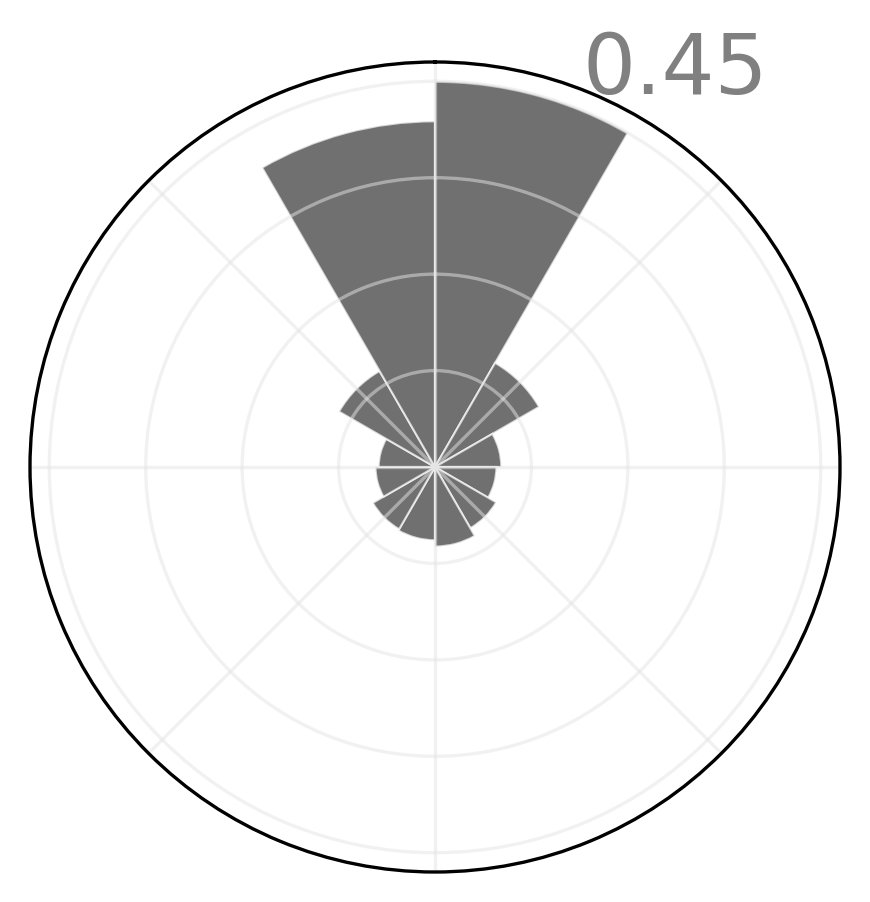

In [19]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'}, figsize=(3, 4), dpi=300)

colors = {
    'bars': '#333333',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',          # Nearly black for clear text
}

bins = np.linspace(0, 2*np.pi, 36)

plot_circular_histogram(
    np.array(BumpAngle_2_goal), 
    bins=12, 
    density=True, 
    ax=ax, 
    colors=colors, 
    fontsize=20, 
    show_xlabels=False, 
)

# ax.hist(BumpAngle_2_goal, bins=bins, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)
# ax0.set_title('S.D. vs G.D.', fontsize=8)

# fig.savefig('figures/PaperFig/theta_sweep_sd_vs_gd.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

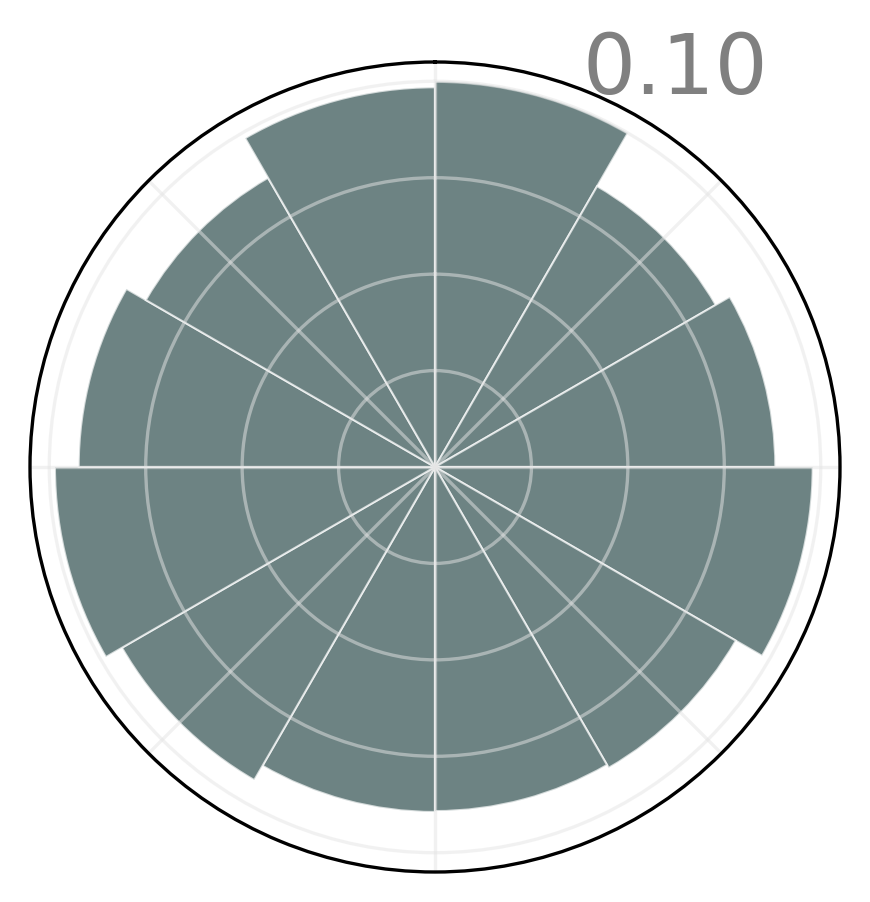

In [18]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'}, figsize=(3, 4), dpi=300)

colors = {
    'bars': '#2F4F4F',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',          # Nearly black for clear text
}

bins = np.linspace(0, 2*np.pi, 36)

plot_circular_histogram(
    np.array(BumpAngle_2_MD), 
    bins=12, 
    density=True, 
    ax=ax, 
    colors=colors, 
    fontsize=20, 
    show_xlabels=False, 
)

# ax.hist(BumpAngle_2_goal, bins=bins, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)
# ax0.set_title('S.D. vs G.D.', fontsize=8)

# fig.savefig('figures/PaperFig/theta_sweep_sd_vs_md.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

/Users/changminyu/Desktop/research/codes/neuroscience/HoneycombSweeps/plotting_utils.py:241: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', '', '', '', '', '', '', ''], fontsize=fontsize)


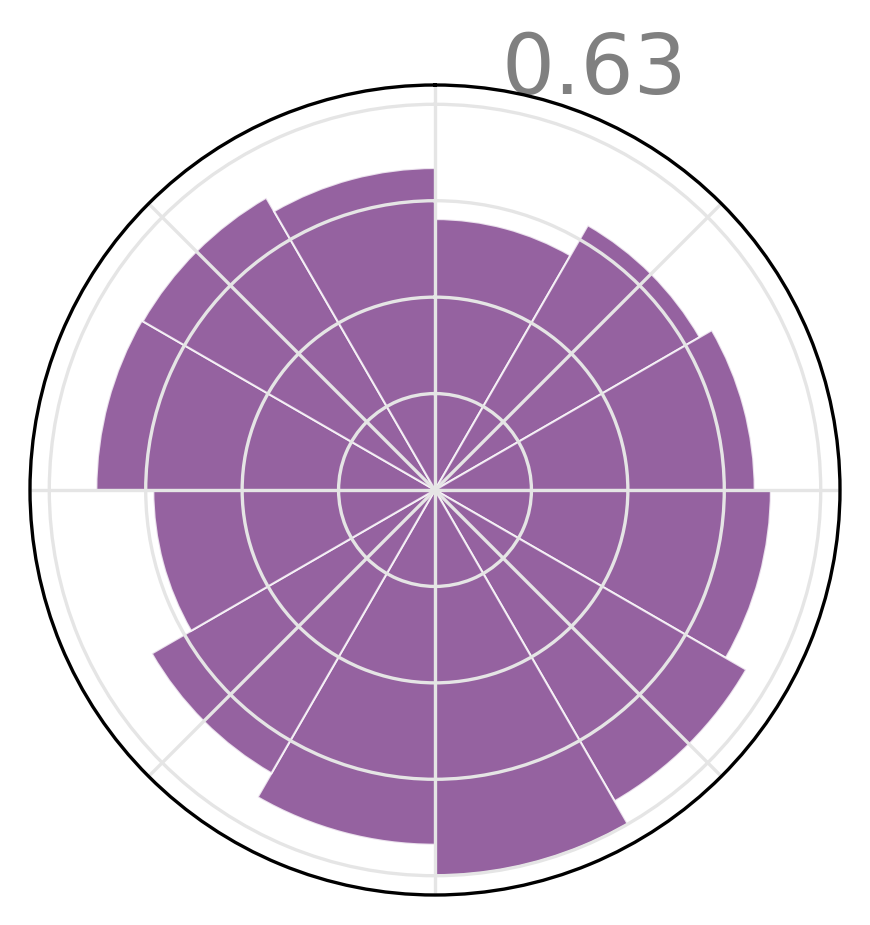

In [13]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'}, figsize=(3, 4), dpi=300)

colors = {
    'bars': '#7B3B89',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',          # Nearly black for clear text
}

n_bins = 12
bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)

mean_sweep_length = np.zeros(n_bins)
for i in range(n_bins):
    # Get the indices of the sweeps that fall into the current bin
    indices = np.where((np.deg2rad(np.array(Angle_at_zeroPhase)) >= bin_edges[i]) & (np.deg2rad(np.array(Angle_at_zeroPhase)) < bin_edges[i + 1]))[0]
    if len(indices) > 0:
        mean_sweep_length[i] = np.mean(np.array(SweepLength)[indices])
    else:
        mean_sweep_length[i] = 0

plot_circular_histogram_with_values(
    fig, 
    ax, 
    mean_sweep_length, 
    bins=bin_edges, 
    colors=colors, 
    fontsize=20,
    normalize=False, 
    show_dir_bins=False, 
)

# # Prepare angles for bar centres
# bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

# # Plot as polar histogram (bar plot)
# ax.bar(bin_centres, mean_sweep_length, width=(2 * np.pi / n_bins), bottom=0.0, color='darkorange', edgecolor='grey', linewidth=0.5)

fig.savefig('figures/PaperFig/theta_sweep_sl_vs_gd.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

In [9]:
Angle_at_zeroPhase

[np.float64(104.94226793635235),
 np.float64(128.86112280963823),
 np.float64(4.05777836714936),
 np.float64(325.5591590921359),
 np.float64(281.1964667825539),
 np.float64(235.34251791257907),
 np.float64(194.25972190328008),
 np.float64(158.9390726202346),
 np.float64(255.13874899051382),
 np.float64(125.35760845633057),
 np.float64(95.99965056160478),
 np.float64(66.86208403198735),
 np.float64(36.49679697662381),
 np.float64(3.063361333156292),
 np.float64(324.17625735818655),
 np.float64(278.8938951999665),
 np.float64(232.34219862593025),
 np.float64(216.0804759055537),
 np.float64(177.36311722847594),
 np.float64(144.4511291680619),
 np.float64(114.64186136563453),
 np.float64(86.0248392680569),
 np.float64(57.13890874912293),
 np.float64(26.417781978343253),
 np.float64(351.64864561896667),
 np.float64(278.3715411065926),
 np.float64(85.95576778988074),
 np.float64(135.3937355706787),
 np.float64(176.2035364838352),
 np.float64(209.6449674414636),
 np.float64(239.2055642705535)

In [14]:
# Shade each sector of the polar plot with the respective color
# for i in range(360 // 30):
#     ax.fill_between([np.radians(i * 30), np.radians((i + 1) * 30)], 0, 0.8, color=colors[i], alpha=0.5)

scatter_angles = []
scatter_distances = []
scatter_colors = []
scatter_alphas = []

sweep_info = {}

#clasifiy sweeps into 12 bins with 30 degree each
for goal_ang, sweep_angs, sweep_dist in zip(Angle_at_zeroPhase, BumpAngle_at_all_phase, BumpDist_2_pos):
    goal_ang = goal_ang % 360
    indx = int(goal_ang // 30)
    #append sweep_angs and sweep_dist to a dictionary with indx as key
    if indx not in sweep_info:
        sweep_info[indx] = []
    sweep_info[indx].append((sweep_angs, sweep_dist))
    
expected_sweeps = {}
for i in range(12):
    sweep_info_val = sweep_info[i]
    SA = []
    SD = []
    for sweep_angs, sweep_dist in sweep_info_val:
        # SA.append(sweep_angs[start:end])
        # SD.append(sweep_dist[start:end])
        SA.append(sweep_angs)
        SD.append(sweep_dist)        
    #to numpy array using stack
    SA = np.stack(SA)
    SD = np.stack(SD)
    
    # Convert angles in SA to complex numbers
    complex_angles = np.exp(1j * np.radians(SA))  # Convert angles to radians and then to complex form
    mean_complex = np.mean(complex_angles, axis=0)  # Calculate mean in complex plane
    SA_mean = np.degrees(np.angle(mean_complex)) % 360  # Convert back to degrees and wrap to 0-360
    
    # Calculate mean distance
    SD_mean = np.mean(SD, axis=0)
    
    expected_sweep_temp = np.zeros((len(SA_mean), 2))
    for j in range(len(SD_mean)):
        expected_sweep_temp[j] = np.array([
            np.sin(np.deg2rad(SA_mean[j])) * SD_mean[j],
            np.cos(np.deg2rad(SA_mean[j])) * SD_mean[j], 
        ])
    expected_sweeps[i] = expected_sweep_temp

0
1
2
3
4
5
6
7
8
9
10
11


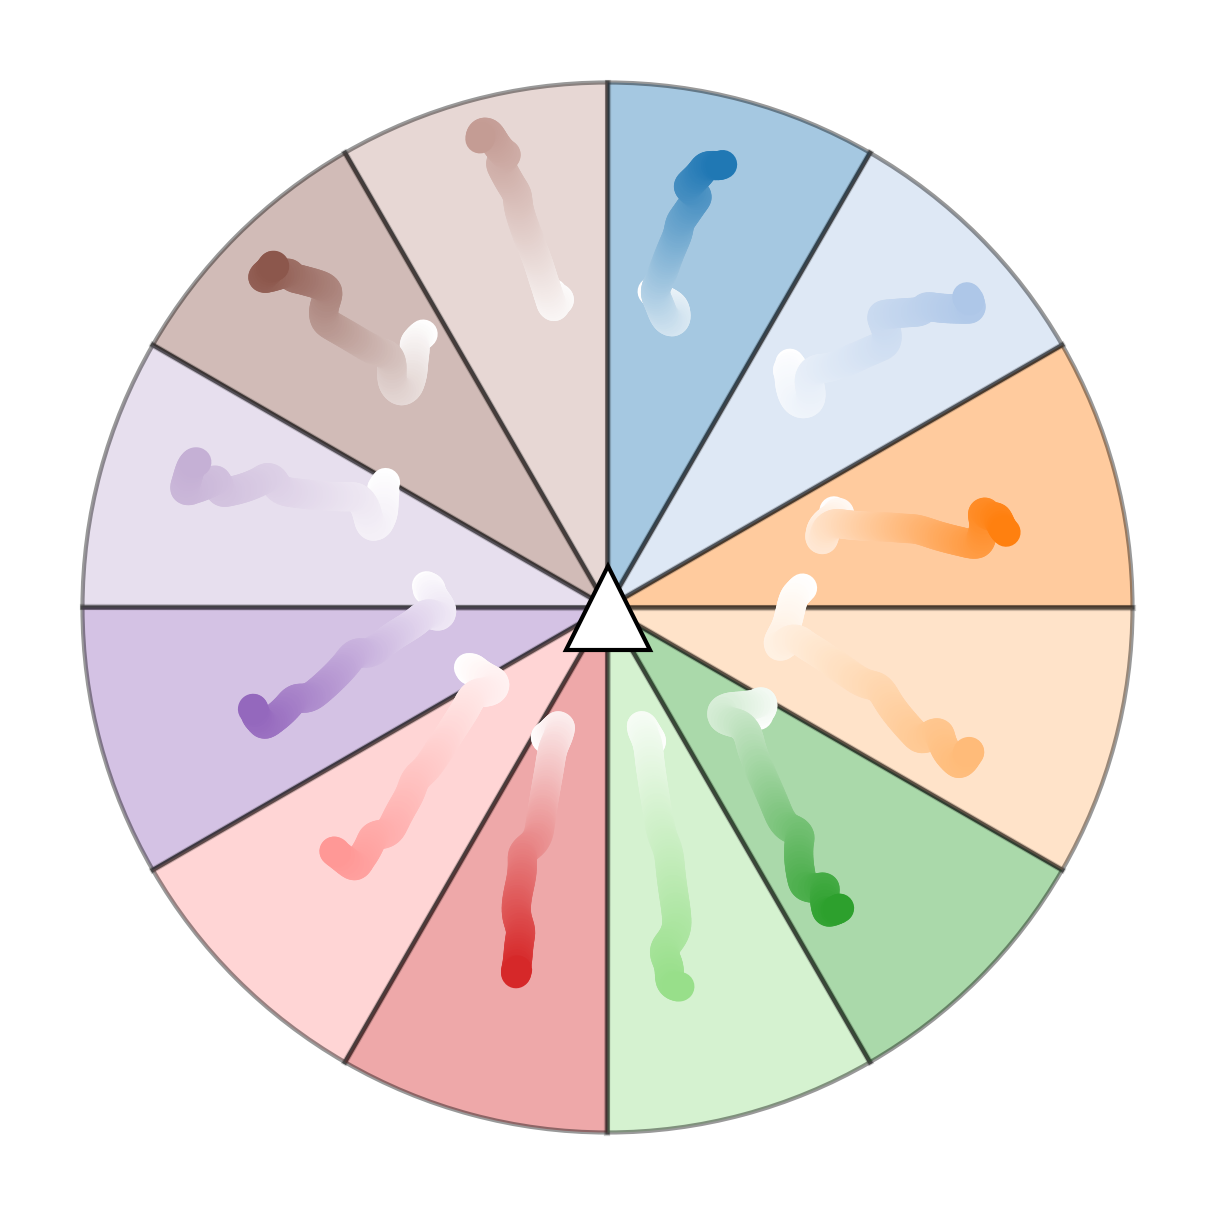

In [17]:
start_ind = 0
end_ind = 50

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
plot_expected_theta_sweep(
    expected_sweeps, 
    ax=ax, 
    fontsize=20, 
    start_theta_sweep_ind=start_ind, 
    end_theta_sweep_ind=end_ind, 
    radius=.75, 
    plot_scalar_bar=False, 
    linewidth=7, 
)

fig.savefig('figures/PaperFig/expected_theta_sweep.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

# no td

In [7]:
import seaborn as sns
from scipy.signal import find_peaks
from matplotlib.colors import LinearSegmentedColormap

def create_custom_trajectory_cmap(target_color):
    """
    Create a colormap that transitions from white to the target color.

    Parameters
    ----------
    target_color : tuple or str
        A colour accepted by matplotlib (e.g., an RGB/RGBA tuple or a named string)

    Returns
    -------
    LinearSegmentedColormap
        A custom colormap object
    """
    return LinearSegmentedColormap.from_list('custom_cmap', ['white', target_color])


start = 15; end = 65 #extract a middle period as Changmin did in empirical data analysis. He used 15°-195° in 360°, so we used 15-65 in 100. 
num = 50
z_max = np.pi

#find peak using scipy.signal.find_peaks
peaks, _ = find_peaks(theta_phase_no_td)
peaks -= 50 #get the trough!!! So that we plot the averaged sweeps like Changmin did in his lateset analysis where he used MUA
# troughs, _ = find_peaks(-theta_phase)       # for minima

#plot theta_rhythm and mark peaks as red dots
# fig, axs = plt.subplots(1, 3, figsize=(10, 3), dpi=100)
#gridspec
fig = plt.figure(figsize=(8, 2), dpi=300)

gs = gridspec.GridSpec(1, 1)

ax = plt.subplot(gs[0])
ax.plot(theta_phase_no_td, color='black')
ax.scatter(peaks, theta_rhythm_no_td[peaks], color='#009FB9', s=20)
# ax.scatter(troughs, theta_rhythm[troughs], color='blue', s=20)
ax.set_xlim(0, 3000)
ax.set_ylim(np.min(theta_rhythm_no_td[:3000]), np.max(theta_rhythm_no_td[:3000]))
ax.set_xlabel('Time (ms)')
ax.set_ylabel('Theta')
sns.despine()

Angle_at_zeroPhase = []
BumpAngle_2_goal = [] #same dimension as Angle_at_zeroPhase
BumpAngle_2_MD = []
BumpAngle_2_HD = []

BumpAngle_at_all_phase = []
BumpDist_2_pos = []
SweepLength = []
InitOffsetAngle2goal = []
InitOffsetDist = []
InitOffsetAngle2md = []

#at each peak, calculate the angle between moving direction and the vector from the Position to the goal location
for i in range(len(peaks)-1):
    #calculate the vector from the Position to the goal location
    vec = np.array([goal_loc[0] - animal_head_loc_all_no_td[peaks[i], 0], goal_loc[1] - animal_head_loc_all_no_td[peaks[i], 1]])
    #calculate the angle between vec and moving direction
    angle = np.arctan2(vec[1], vec[0]) - np.arctan2(velocity_all_no_td[peaks[i], 1], velocity_all_no_td[peaks[i], 0])
    angle = np.degrees(angle) % 360
    Angle_at_zeroPhase.append(angle)

    bumpTraj_in_Acycle = pc_bump_center_no_td[peaks[i]:peaks[i+1], :]       #/num * z_max

    #using 20th point as initial offset
    init_offset_loc = bumpTraj_in_Acycle[start,:]
    #calculate the vect from offset loc to position 
    init_offset_vec = np.array([init_offset_loc[0] - animal_head_loc_all_no_td[peaks[i]+start, 0], init_offset_loc[1] - animal_head_loc_all_no_td[peaks[i]+start, 1]])
    #init offset dist
    int_offset_dist = np.linalg.norm(init_offset_vec)
    InitOffsetDist.append(int_offset_dist)
    
    #calculate the angle between offset_vec and direction to goal
    init_offset_angle = np.arctan2(init_offset_vec[1], init_offset_vec[0]) - np.arctan2(vec[1], vec[0])
    #wrap to 0-360
    init_offset_angle = np.degrees(init_offset_angle) % 360
    #change to radians
    init_offset_angle = np.radians(init_offset_angle)
    #append to InitOffsetAngle2goal
    InitOffsetAngle2goal.append(init_offset_angle)
    
    #calculate the angle between offset_vec and moving direction
    init_offset_angle2md = np.arctan2(init_offset_vec[1], init_offset_vec[0]) - np.arctan2(velocity_all_no_td[peaks[i], 1], velocity_all_no_td[peaks[i], 0])
    #wrap to 0-360
    init_offset_angle2md = np.degrees(init_offset_angle2md) % 360
    #chnage to radians
    init_offset_angle2md = np.radians(init_offset_angle2md)
    InitOffsetAngle2md.append(init_offset_angle2md)    
        
    # sweep_length = np.linalg.norm(bumpTraj_in_Acycle[start,:] - bumpTraj_in_Acycle[end,:])
    # sweep_length = np.linalg.norm(Animal_location_all[peaks[i], :] - bumpTraj_in_Acycle[end,:])
    
    # start_point = bumpTraj_in_Acycle[start, :]
    # # start_point = Animal_location_all[peaks[i], :]
    # distances = np.linalg.norm(bumpTraj_in_Acycle - start_point, axis=1)
    # sweep_length = np.max(distances)

    pos_in_Acycle = animal_head_loc_all_no_td[peaks[i]:peaks[i+1], :]
    # start_point = Animal_location_all[peaks[i], :]
    distances = np.linalg.norm(bumpTraj_in_Acycle - pos_in_Acycle, axis=1)
    sweep_length = np.max(distances) - np.min(distances)  # Calculate the range of distances
    
    SweepLength.append(sweep_length)
    
    BumpAngle = []
    BumpDist = []
    
    # for j in range(len(bumpTraj_in_Acycle)):
    for j in range(start, end):
        pos2goal_vec = np.array([goal_loc[0] - pos_in_Acycle[j, 0], goal_loc[1] - pos_in_Acycle[j, 1]])
        #calculate sweep direction relative to position
        vec2 = np.array([bumpTraj_in_Acycle[j, 0] - pos_in_Acycle[j, 0], bumpTraj_in_Acycle[j, 1] - pos_in_Acycle[j, 1]])
        # Calculate sweep angle relative to goal
        angle2 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(pos2goal_vec[1], pos2goal_vec[0])
        angle2 = np.degrees(angle2) % 360
        angle2 = np.radians(angle2)  # Convert to radians
        BumpAngle_2_goal.append(angle2)
        
        #calculate the angle between sweeps and moving direction
        angle3 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(velocity_all_no_td[peaks[i]+j, 1], velocity_all_no_td[peaks[i]+j, 0])
        angle3 = np.degrees(angle3) % 360
        BumpAngle.append(angle3)
        angle3 = np.radians(angle3)  # Convert to radians
        BumpAngle_2_MD.append(angle3)
        
        #calculate the angle betweens sweeps and head direction
        HD_vec = np.array([np.cos(hd_all_no_td[peaks[i]+j]), np.sin(hd_all_no_td[peaks[i]+j])])
        angle4 = np.arctan2(vec2[1], vec2[0]) - np.arctan2(HD_vec[1], HD_vec[0])
        angle4 = np.degrees(angle4) % 360
        angle4 = np.radians(angle4)  # Convert to radians
        BumpAngle_2_HD.append(angle4)
        
        #calculate bump distance to the position
        dist = np.linalg.norm(vec2)
        # dist = np.where(dist > 0.5, 1.0 - dist, dist)
        BumpDist.append(dist)
        
    BumpAngle_at_all_phase.append(BumpAngle)
    BumpDist_2_pos.append(BumpDist)

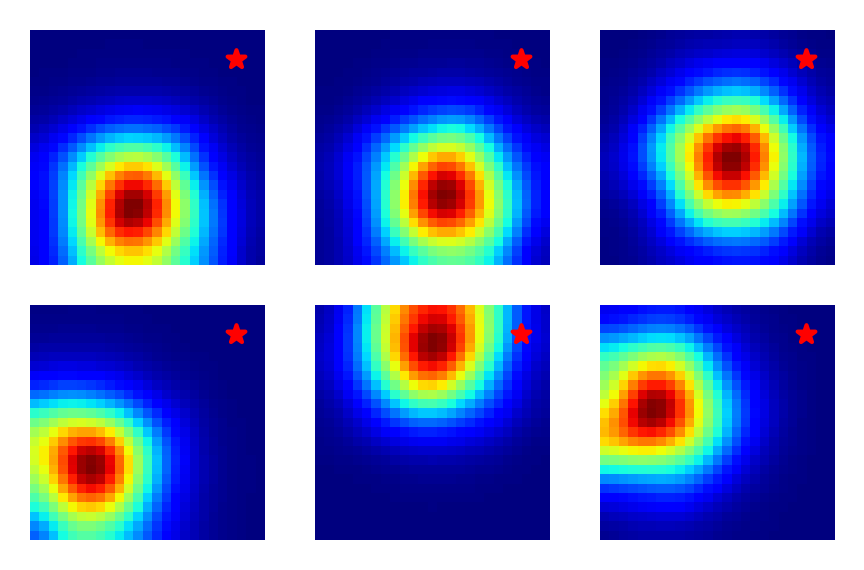

In [9]:

#plot all the firing rates in a single merged image

num = 50

fig, axs = plt.subplots(2, 3, figsize=(3,2), dpi=300)

dim = num//2
Position_norm = (animal_head_loc_all_no_td - animal_head_loc_all_no_td.min() - 1e-5)/(animal_head_loc_all_no_td.max() - animal_head_loc_all_no_td.min())
#mark the goal location
goal_x = (goal_loc[0]- animal_head_loc_all_no_td.min())/(animal_head_loc_all_no_td.max() - animal_head_loc_all_no_td.min())*dim
goal_y = (goal_loc[1]- animal_head_loc_all_no_td.min())/(animal_head_loc_all_no_td.max() - animal_head_loc_all_no_td.min())*dim

for i in range(6):
    cellindex_x = np.random.randint(12, 38)
    cellindex_y = np.random.randint(12, 38)
    map = get_tuningMap(pc_activity_no_td, 
                        Position_norm, 
                        cellindex_x=cellindex_x,
                        cellindex_y=cellindex_y,
                        filter= True,
                        samples_per_sec=1000,
                        dim=dim)
    
    #5 row and 2 cols
    ax = axs[i // 3, i % 3]

    ax.scatter(goal_x, goal_y, color='red', marker='*', s=20)

    ax.set_xticks([])
    ax.set_yticks([])
    ax.axis('off')  
    ax.imshow(map, cmap='jet', origin='lower')
    
    ax.grid(False)

plt.tight_layout()
plt.savefig('figures/PaperFig/Example_place_maps_no_td.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.show()


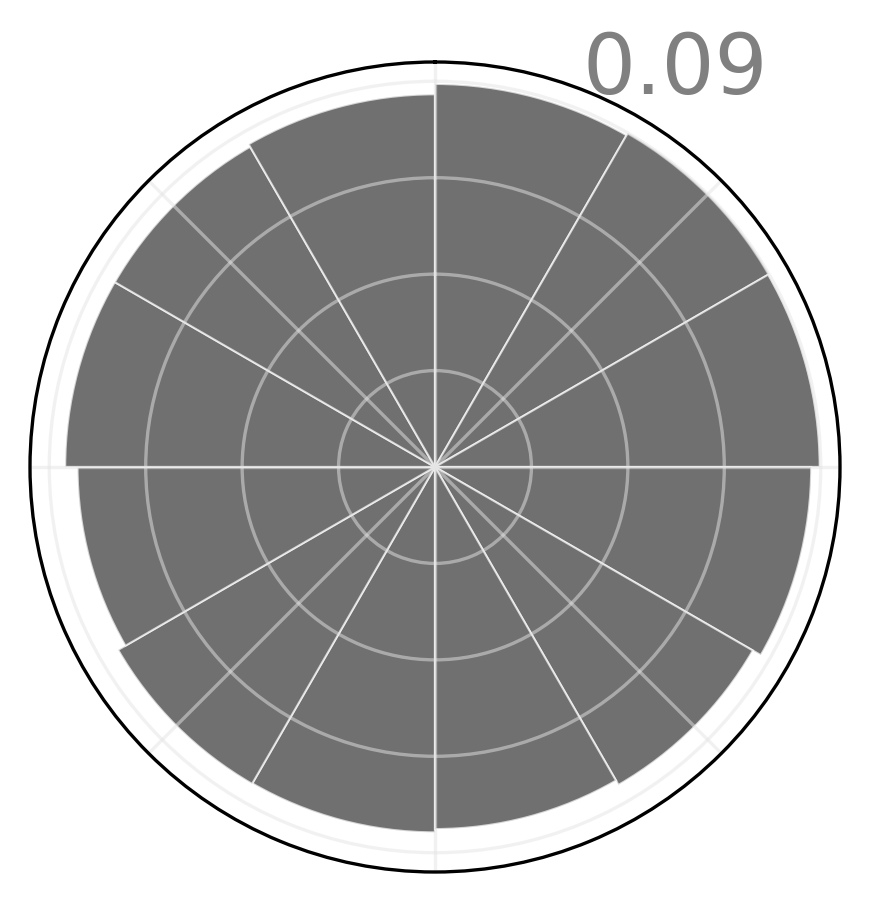

In [11]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'}, figsize=(3, 4), dpi=300)

colors = {
    'bars': '#333333',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',          # Nearly black for clear text
}

bins = np.linspace(0, 2*np.pi, 36)

plot_circular_histogram(
    np.array(BumpAngle_2_goal), 
    bins=12, 
    density=True, 
    ax=ax, 
    colors=colors, 
    fontsize=20, 
    show_xlabels=False, 
)

# ax.hist(BumpAngle_2_goal, bins=bins, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)
# ax0.set_title('S.D. vs G.D.', fontsize=8)

fig.savefig('figures/PaperFig/theta_sweep_sd_vs_gd_no_td.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

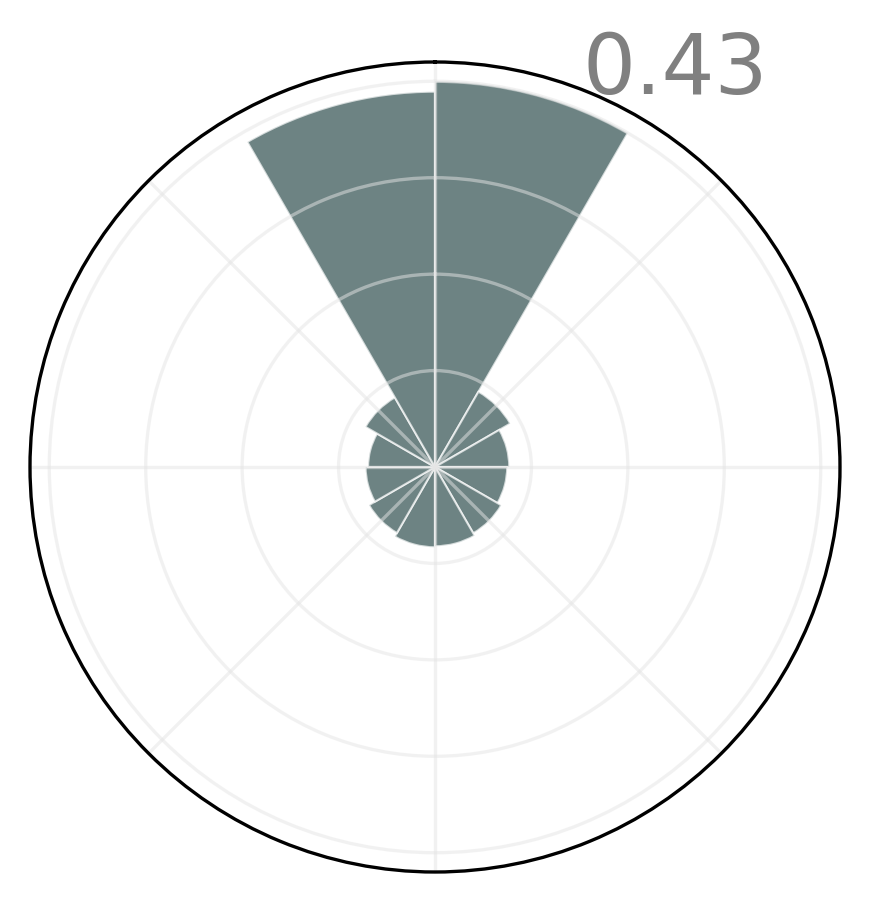

In [12]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'}, figsize=(3, 4), dpi=300)

colors = {
    'bars': '#2F4F4F',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',          # Nearly black for clear text
}

bins = np.linspace(0, 2*np.pi, 36)

plot_circular_histogram(
    np.array(BumpAngle_2_MD), 
    bins=12, 
    density=True, 
    ax=ax, 
    colors=colors, 
    fontsize=20, 
    show_xlabels=False, 
)

# ax.hist(BumpAngle_2_goal, bins=bins, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)
# ax0.set_title('S.D. vs G.D.', fontsize=8)

fig.savefig('figures/PaperFig/theta_sweep_sd_vs_md_no_td.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

/Users/changminyu/Desktop/research/codes/neuroscience/HoneycombSweeps/plotting_utils.py:245: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', '', '', '', '', '', '', ''], fontsize=fontsize)


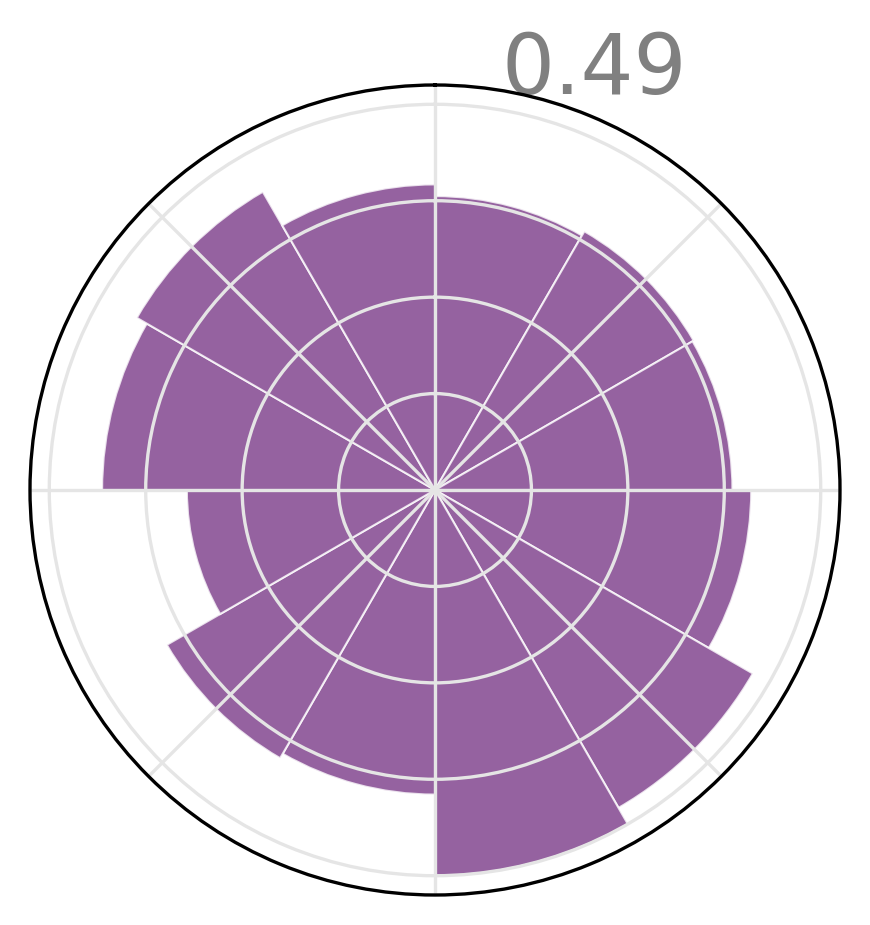

In [13]:
fig, ax = plt.subplots(1, 1, subplot_kw={'projection': 'polar'}, figsize=(3, 4), dpi=300)

colors = {
    'bars': '#7B3B89',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',          # Nearly black for clear text
}

n_bins = 12
bin_edges = np.linspace(0, 2 * np.pi, n_bins + 1)

mean_sweep_length = np.zeros(n_bins)
for i in range(n_bins):
    # Get the indices of the sweeps that fall into the current bin
    indices = np.where((np.deg2rad(np.array(Angle_at_zeroPhase)) >= bin_edges[i]) & (np.deg2rad(np.array(Angle_at_zeroPhase)) < bin_edges[i + 1]))[0]
    if len(indices) > 0:
        mean_sweep_length[i] = np.mean(np.array(SweepLength)[indices])
    else:
        mean_sweep_length[i] = 0

plot_circular_histogram_with_values(
    fig, 
    ax, 
    mean_sweep_length, 
    bins=bin_edges, 
    colors=colors, 
    fontsize=20,
    normalize=False, 
    show_dir_bins=False, 
)

# # Prepare angles for bar centres
# bin_centres = (bin_edges[:-1] + bin_edges[1:]) / 2

# # Plot as polar histogram (bar plot)
# ax.bar(bin_centres, mean_sweep_length, width=(2 * np.pi / n_bins), bottom=0.0, color='darkorange', edgecolor='grey', linewidth=0.5)

fig.savefig('figures/PaperFig/theta_sweep_sl_vs_gd_no_td.pdf', dpi=300, transparent=True, bbox_inches='tight')
plt.show()

1.1088553058889788e-36
1.3158557666466174e-35


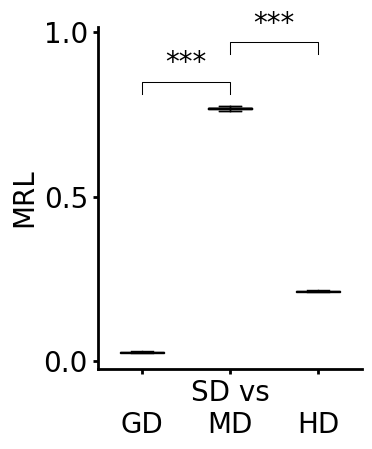

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
BumpAngle_2_goal = np.array(BumpAngle_2_goal)
BumpAngle_2_MD = np.array(BumpAngle_2_MD)
BumpAngle_2_HD = np.array(BumpAngle_2_HD)

inds = [np.random.choice(range(len(BumpAngle_2_goal)), len(BumpAngle_2_goal)//10, replace=False) for _ in range(10)]
mrl_sd_vs_gd = [circular_mean_resultant_vector_length(BumpAngle_2_goal[i]) for i in inds]
mrl_sd_vs_md = [circular_mean_resultant_vector_length(BumpAngle_2_MD[i]) for i in inds]
mrl_sd_vs_hd = [circular_mean_resultant_vector_length(BumpAngle_2_HD[i]) for i in inds]

plot_paired_boxplot(
    np.array(mrl_sd_vs_gd), 
    np.array(mrl_sd_vs_md),
    pos1=1, 
    pos2=2, 
    labels=["#333333", "#2F4F4F"], 
    plot_paired_lines=False, 
    ax=ax, 
    fontsize=20, 
    alternative="two-sided", 
)

plot_paired_boxplot(
    np.array(mrl_sd_vs_md), 
    np.array(mrl_sd_vs_hd),
    pos1=2, 
    pos2=3, 
    labels=["", ""], 
    plot_paired_lines=False, 
    ax=ax, 
    ylabel="MRL",
    y_max=.9, 
    fontsize=20, 
    colors=["#2F4F4F", "#8B4513"], 
    alternative="two-sided", 
)

ax.set_yticks([0.0, 0.5, 1.0])
ax.set_xticks([1, 2, 3])
ax.set_xticklabels([
    " \nGD", 
    "SD vs\nMD",
    " \nHD", 
], fontsize=20)

fig.savefig('figures/PaperFig/theta_sweep_vs_various_directions_mrl_no_td.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

In [19]:
# Shade each sector of the polar plot with the respective color
# for i in range(360 // 30):
#     ax.fill_between([np.radians(i * 30), np.radians((i + 1) * 30)], 0, 0.8, color=colors[i], alpha=0.5)

scatter_angles = []
scatter_distances = []
scatter_colors = []
scatter_alphas = []

sweep_info = {}

#clasifiy sweeps into 12 bins with 30 degree each
for goal_ang, sweep_angs, sweep_dist in zip(Angle_at_zeroPhase, BumpAngle_at_all_phase, BumpDist_2_pos):
    goal_ang = goal_ang % 360
    indx = int(goal_ang // 30)
    #append sweep_angs and sweep_dist to a dictionary with indx as key
    if indx not in sweep_info:
        sweep_info[indx] = []
    sweep_info[indx].append((sweep_angs, sweep_dist))
    
expected_sweeps = {}
for i in range(12):
    sweep_info_val = sweep_info[i]
    SA = []
    SD = []
    for sweep_angs, sweep_dist in sweep_info_val:
        # SA.append(sweep_angs[start:end])
        # SD.append(sweep_dist[start:end])
        SA.append(sweep_angs)
        SD.append(sweep_dist)        
    #to numpy array using stack
    SA = np.stack(SA)
    SD = np.stack(SD)
    
    # Convert angles in SA to complex numbers
    complex_angles = np.exp(1j * np.radians(SA))  # Convert angles to radians and then to complex form
    mean_complex = np.mean(complex_angles, axis=0)  # Calculate mean in complex plane
    SA_mean = np.degrees(np.angle(mean_complex)) % 360  # Convert back to degrees and wrap to 0-360
    
    # Calculate mean distance
    SD_mean = np.mean(SD, axis=0)
    
    expected_sweep_temp = np.zeros((len(SA_mean), 2))
    for j in range(len(SD_mean)):
        expected_sweep_temp[j] = np.array([
            np.sin(np.deg2rad(SA_mean[j])) * SD_mean[j],
            np.cos(np.deg2rad(SA_mean[j])) * SD_mean[j], 
        ])
    expected_sweeps[i] = expected_sweep_temp

0
1
2
3
4
5
6
7
8
9
10
11


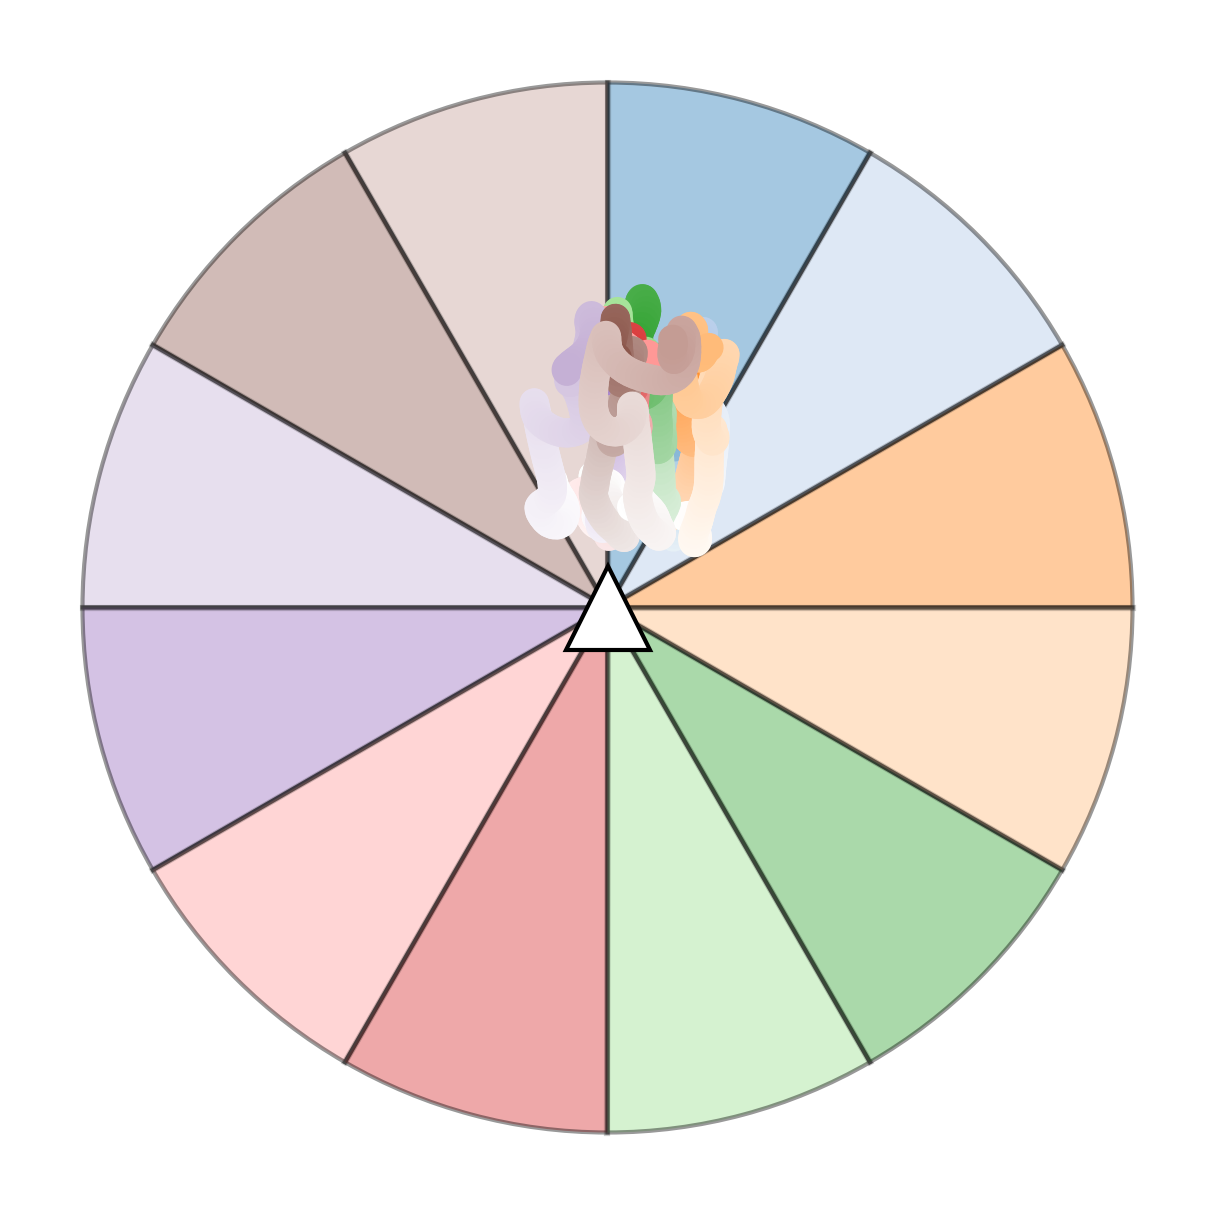

In [32]:
start_ind = 0
end_ind = 50

fig, ax = plt.subplots(1, 1, figsize=(5, 5), dpi=300)
plot_expected_theta_sweep(
    expected_sweeps, 
    ax=ax, 
    fontsize=20, 
    start_theta_sweep_ind=start_ind, 
    end_theta_sweep_ind=end_ind, 
    radius=0.4, 
    plot_scalar_bar=False, 
    linewidth=7, 
    centre=np.array([0, 0.4])
)

fig.savefig('figures/PaperFig/expected_theta_sweep_no_td.pdf', dpi=300, transparent=True, bbox_inches='tight')

plt.show()

In [35]:
import pickle
(mrl_sd_vs_gd_with_td, mrl_sd_vs_md_with_td, mrl_sd_vs_hd_with_td) = pickle.load(
    open("logs/mrl_sd_vs_gd_md_hd_with_td.pkl", "rb"), 
)

1.9803354532977945e-38


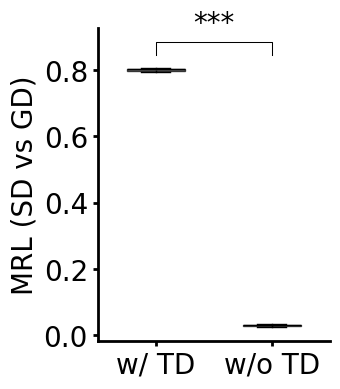

In [47]:
fig, ax = plt.subplots(figsize=(3.5, 4))
plot_paired_boxplot(
    np.array(mrl_sd_vs_gd_with_td), 
    np.array(mrl_sd_vs_gd),
    pos1=1, 
    pos2=2, 
    colors=["#333333", "#333333"], 
    plot_paired_lines=False, 
    ax=ax, 
    fontsize=20, 
    alternative="two-sided", 
    ylabel="MRL (SD vs GD)",
    alpha=0.7, 
    labels=["w/ TD", "w/o TD"],
)

fig.savefig("figures/PaperFig/mrl_sd_vs_gd_with_vs_without_td.pdf", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

3.6838328793964646e-36


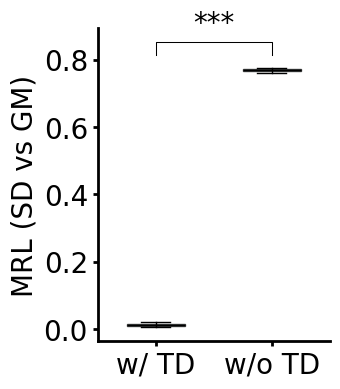

In [48]:
fig, ax = plt.subplots(figsize=(3.5, 4))
plot_paired_boxplot(
    np.array(mrl_sd_vs_md_with_td), 
    np.array(mrl_sd_vs_md),
    pos1=1, 
    pos2=2, 
    colors=["#2F4F4F", "#2F4F4F"], 
    plot_paired_lines=False, 
    ax=ax, 
    fontsize=20, 
    alternative="two-sided", 
    ylabel="MRL (SD vs GM)",
    alpha=0.7, 
    labels=["w/ TD", "w/o TD"],
)

fig.savefig("figures/PaperFig/mrl_sd_vs_md_with_vs_without_td.pdf", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

3.930015051048908e-25


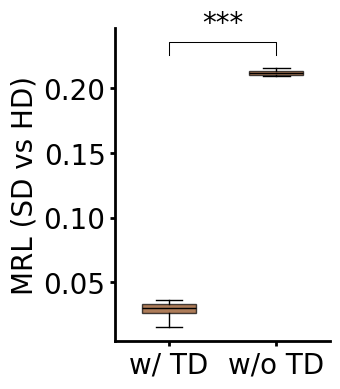

In [49]:
fig, ax = plt.subplots(figsize=(3.5, 4))
plot_paired_boxplot(
    np.array(mrl_sd_vs_hd_with_td), 
    np.array(mrl_sd_vs_hd),
    pos1=1, 
    pos2=2, 
    colors=["#8B4513", "#8B4513"], 
    plot_paired_lines=False, 
    ax=ax, 
    fontsize=20, 
    alternative="two-sided", 
    ylabel="MRL (SD vs HD)",
    alpha=0.7, 
    labels=["w/ TD", "w/o TD"],
)

fig.savefig("figures/PaperFig/mrl_sd_vs_hd_with_vs_without_td.pdf", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

1.9803354532977945e-38
3.6838328793964646e-36
3.930015051048908e-25


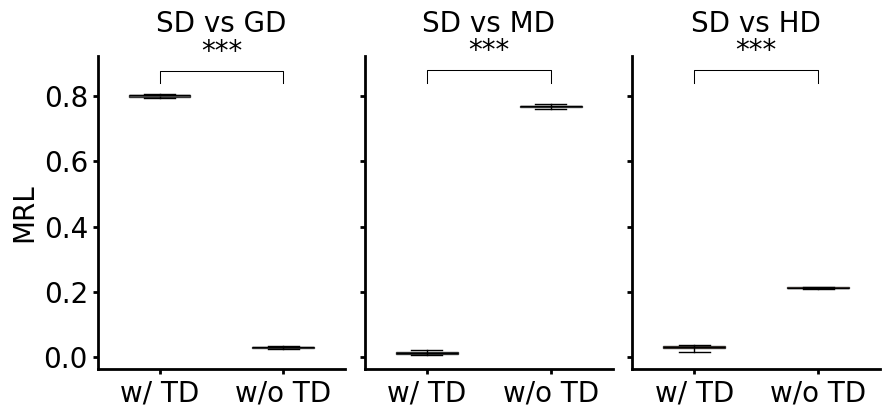

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(9, 4), sharey=True)

plot_paired_boxplot(
    np.array(mrl_sd_vs_gd_with_td), 
    np.array(mrl_sd_vs_gd),
    pos1=1, 
    pos2=2, 
    colors=["#333333", "#333333"], 
    plot_paired_lines=False, 
    ax=ax[0], 
    fontsize=20, 
    alternative="two-sided", 
    ylabel="MRL",
    alpha=0.7, 
    labels=["w/ TD", "w/o TD"],
    y_max=0.8, 
)

plot_paired_boxplot(
    np.array(mrl_sd_vs_md_with_td), 
    np.array(mrl_sd_vs_md),
    pos1=1, 
    pos2=2, 
    colors=["#2F4F4F", "#2F4F4F"], 
    plot_paired_lines=False, 
    ax=ax[1], 
    fontsize=20, 
    alternative="two-sided", 
    ylabel="",
    alpha=0.7, 
    labels=["w/ TD", "w/o TD"],
    y_max=0.8, 
)

plot_paired_boxplot(
    np.array(mrl_sd_vs_hd_with_td), 
    np.array(mrl_sd_vs_hd),
    pos1=1, 
    pos2=2, 
    colors=["#8B4513", "#8B4513"], 
    plot_paired_lines=False, 
    ax=ax[2], 
    fontsize=20, 
    alternative="two-sided", 
    ylabel="",
    alpha=0.7, 
    labels=["w/ TD", "w/o TD"],
    y_max=0.8
)

ax[0].set_title("SD vs GD", fontsize=20, y=1.05)
ax[1].set_title("SD vs MD", fontsize=20, y=1.05)
ax[2].set_title("SD vs HD", fontsize=20, y=1.05)

fig.savefig("figures/PaperFig/mrl_sd_vs_gd_md_hd_with_vs_without_td.pdf", dpi=300, transparent=True, bbox_inches='tight')

plt.show()

In [61]:
def get_anticipatory(pc_activity_i, relative_angle, rotation_direction, direction='clockwise', num_bins=36, normalize_rate=False):
    """
    Compute the anticipatory activity of place cells based on relative angles.

    Parameters:
    - pc_activity_i: 1D array of place cell activity.
    - relative_angle: 1D array of relative angles.
    - rotation_direction: 1D array of rotation direction flags (e.g., 1 for CW, -1 for CCW, 0 for stationary).
    - direction: 'clockwise', 'counter_clockwise', or 'nonscanning'
    - num_bins: Number of angular bins.

    Returns:
    - binned_activity: Summed activity per angle bin.
    - dwell_time_per_bin: Number of samples per bin.
    """

    # Filter based on specified rotation direction
    if direction == 'clockwise':
        mask = rotation_direction == 1
    elif direction == 'counter_clockwise':
        mask = rotation_direction == -1
    elif direction == 'nonscanning':
        mask = rotation_direction == 0
    else:
        raise ValueError("Invalid direction. Use 'clockwise', 'counter_clockwise', or 'nonscanning'.")

    activity = pc_activity_i[mask]
    angles = relative_angle[mask]

    # Define bins and digitise
    angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
    # bin_indices = np.digitize(angles, angle_bins) - 1
    bin_indices = np.digitize(angles, angle_bins, right=False) - 1
    
    # Clip to valid bin range
    bin_indices = np.clip(bin_indices, 0, num_bins - 1)

    # Initialise outputs
    binned_activity = np.zeros(num_bins)
    dwell_time_per_bin = np.zeros(num_bins)

    # Accumulate values efficiently
    np.add.at(binned_activity, bin_indices, activity)
    np.add.at(dwell_time_per_bin, bin_indices, 1)

    if normalize_rate==True:
        return binned_activity/dwell_time_per_bin
    else:
        return binned_activity


def get_relativeDir2Goal(Animal_location, Head_direction, goal_loc):
    """
    Compute the relative direction to the goal for each position and head direction.
    
    Parameters:
    - Animal_location_all: Array of animal positions (Nx2).
    - Head_direction_all: Array of head directions (N,).
    - goal_loc: Goal location as a 2D array [x, y].
    
    Returns:
    - relative_angle2goal: Array of relative angles to the goal (N,).
    """

    # Ensure goal_loc is a numpy array
    goal_loc = np.array(goal_loc)

    # Vector from current position to consink
    vec = goal_loc - Animal_location  # shape (N, 2)
    vec_angle = np.arctan2(vec[:, 1], vec[:, 0])  # angle to consink

    # Compute head-relative angle, wrap to [-π, π]
    relative_angle2goal = (vec_angle - Head_direction + np.pi) % (2 * np.pi) - np.pi
        
    return relative_angle2goal


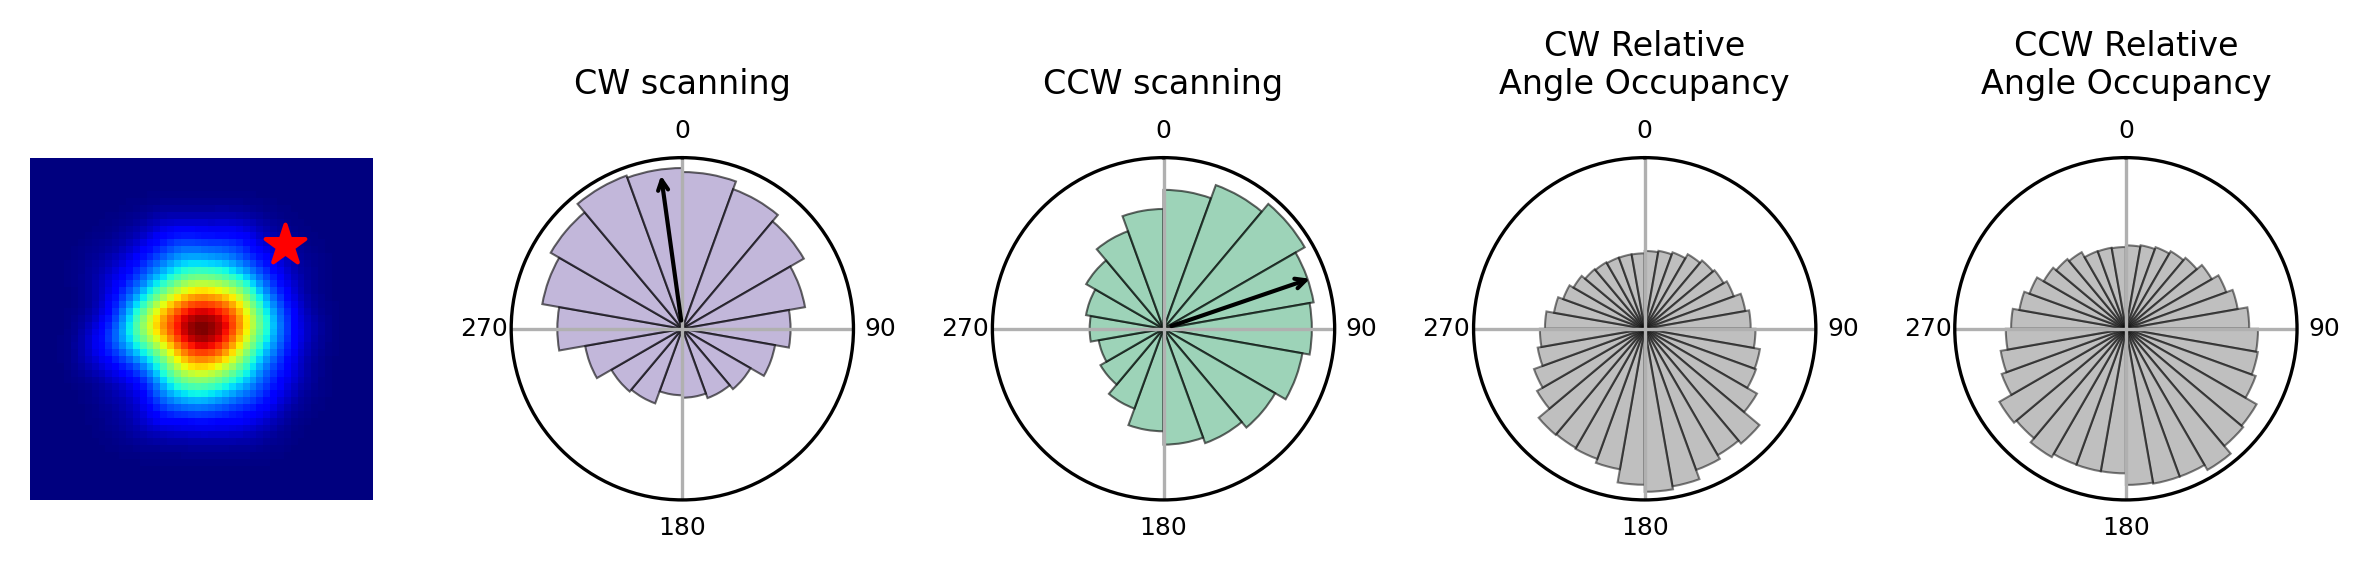

In [62]:
# goal_loc = [0.5*np.pi, 0.5*np.pi]
# goal_loc_in_traj = np.array(goal_loc)/np.pi + 0.5

# rand_loc = [-0.5*np.pi, 0.5*np.pi]

rand_loc = goal_loc

cellindex = [25, 25] #18 #25 #32
#mark the goal location
min_loc = -np.pi
max_loc = np.pi

num = 50
num_bins = 18
normalize_rate = True

pc_activity_i=pc_activity_no_td[:, cellindex[0], cellindex[1]]
#cloclwise
relative_angle= get_relativeDir2Goal(animal_head_loc_all_no_td, hd_all_no_td, rand_loc)


fig = plt.figure(figsize=(8, 2), dpi=300)

gs = gridspec.GridSpec(1, 5)

ax = fig.add_subplot(gs[0])

# Position_norm = (Animal_location_all - Animal_location_all.min()-1e-5)/(Animal_location_all.max() - Animal_location_all.min())
Position_norm = (animal_head_loc_all_no_td - min_loc-1e-5)/(max_loc - min_loc)
dim = num
tuningMap = get_tuningMap(pc_activity_no_td, 
                          Position_norm, 
                          cellindex_x=cellindex[0],
                          cellindex_y=cellindex[1],
                          filter=True,
                          samples_per_sec=1000,
                          dim=dim)

ax.imshow(tuningMap, origin='lower', cmap='jet')

# #mark the goal location
# goal_x = (goal_loc[0]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*(dim-1)
# goal_y = (goal_loc[1]- Animal_location_all.min())/(Animal_location_all.max() - Animal_location_all.min())*(dim-1)


goal_x = (rand_loc[0]- min_loc)/(max_loc - min_loc)*(dim-1)
goal_y = (rand_loc[1]- min_loc)/(max_loc - min_loc)*(dim-1)

ax.scatter(goal_x, goal_y, color='red', marker='*', s=100)

ax.set_aspect('equal')

ax.axis('off')

direction='clockwise'
# direction='counter_clockwise'

# relative_angle= get_relativeDir2Goal(Animal_center_all, Head_direction_all, goal_loc)

# Compute anticipatory activity for clockwise direction
binned_activity = get_anticipatory(pc_activity_i, 
                                   relative_angle, 
                                   rotation_direction_flag_all_no_td, 
                                   direction=direction, 
                                   num_bins=num_bins, 
                                   normalize_rate=normalize_rate)

# Define bins for relative angles from -π to π
angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)  # 37 edges for 36 bins
bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2  # Compute bin centers

#get the mean angle 
# Weighted circular mean
mean_angle = np.arctan2(
    np.sum(binned_activity * np.sin(bin_centers)),
    np.sum(binned_activity * np.cos(bin_centers))
)
mean_angle_deg = np.rad2deg(mean_angle) % 360

##########################################################################################################################################

ax = fig.add_subplot(gs[1], projection='polar')

if direction=='clockwise':
    color='#9A88C2'
elif direction=='counter_clockwise':
    color='#5CB68A'

bars = ax.bar(
    bin_centers,
    binned_activity,  # exclude the repeated value
    width=2 * np.pi / num_bins,
    bottom=0.0,
    color=color, #'#2167AC', #28A25F
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)

if direction == 'clockwise':
    ax.set_title('CW scanning', fontsize=8)
elif direction == 'counter_clockwise':
    ax.set_title('CCW scanning', fontsize=8)
# Set the radial limits

#add mean_angle_deg line as an arrow
mean_angle_rad = np.deg2rad(mean_angle_deg)
r_max = np.max(binned_activity)
ax.annotate('', xy=(mean_angle_rad, r_max), xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=1.0),
            fontsize=6, color='black', label=f'Mean Angle: {mean_angle_deg:.1f}°')


#making 0 degree at the top
ax.set_theta_zero_location('N')
#and 90 degree on the right
ax.set_theta_direction(-1) 
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 

ax = fig.add_subplot(gs[3], projection='polar')

if direction == 'clockwise':
    mask = rotation_direction_flag_all_no_td == 1  # Only consider rotation phases
elif direction == 'counter_clockwise':
    mask = rotation_direction_flag_all_no_td == -1  # Only consider rotation phases
else:
    mask = rotation_direction_flag_all_no_td == 0
#plot relative angle
ax.hist(relative_angle[mask], bins=36, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)

ax.set_title('CW Relative\nAngle Occupancy', fontsize=8)
#making 0 degree at the top
ax.set_theta_zero_location('N')
#and 90 degree on the right
ax.set_theta_direction(-1) 
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 


##########################################################################################################################################

direction='counter_clockwise'

# relative_angle= get_relativeDir2Goal(Animal_center_all, Head_direction_all, goal_loc)

# Compute anticipatory activity for clockwise direction
binned_activity = get_anticipatory(pc_activity_i, 
                                   relative_angle, 
                                   rotation_direction_flag_all_no_td, 
                                   direction=direction, 
                                   num_bins=num_bins, 
                                   normalize_rate=normalize_rate)

# Define bins for relative angles from -π to π
angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)  # 37 edges for 36 bins
bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2  # Compute bin centers

#get the mean angle 
# Weighted circular mean
mean_angle = np.arctan2(
    np.sum(binned_activity * np.sin(bin_centers)),
    np.sum(binned_activity * np.cos(bin_centers))
)
mean_angle_deg = np.rad2deg(mean_angle) % 360

ax = fig.add_subplot(gs[2], projection='polar')

if direction=='clockwise':
    color='#9A88C2'
elif direction=='counter_clockwise':
    color='#5CB68A'

bars = ax.bar(
    bin_centers,
    binned_activity,  # exclude the repeated value
    width=2 * np.pi / num_bins,
    bottom=0.0,
    color=color, #'#2167AC', #28A25F
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)

if direction == 'clockwise':
    ax.set_title('CW scanning', fontsize=8)
elif direction == 'counter_clockwise':
    ax.set_title('CCW scanning', fontsize=8)
# Set the radial limits

#add mean_angle_deg line as an arrow
mean_angle_rad = np.deg2rad(mean_angle_deg)
r_max = np.max(binned_activity)
ax.annotate('', xy=(mean_angle_rad, r_max), xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=1.0),
            fontsize=6, color='black', label=f'Mean Angle: {mean_angle_deg:.1f}°')


#making 0 degree at the top
ax.set_theta_zero_location('N')
#and 90 degree on the right
ax.set_theta_direction(-1) 
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 

ax = fig.add_subplot(gs[4], projection='polar')

if direction == 'clockwise':
    mask = rotation_direction_flag_all_no_td == 1  # Only consider rotation phases
elif direction == 'counter_clockwise':
    mask = rotation_direction_flag_all_no_td == -1  # Only consider rotation phases
else:
    mask = rotation_direction_flag_all_no_td == 0
#plot relative angle
ax.hist(relative_angle[mask], bins=36, color='grey', edgecolor='black', linewidth=0.5, alpha=0.5)

ax.set_title('CCW Relative\nAngle Occupancy', fontsize=8)
#making 0 degree at the top
ax.set_theta_zero_location('N')
#and 90 degree on the right
ax.set_theta_direction(-1) 
ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
ax.set_xticklabels(['0', '90', '180', '270'])
#remove y ticks
ax.set_yticks([])
#xtick fontsize as 6
ax.tick_params(labelsize=6)
ax.xaxis.set_tick_params(pad=-4) 


plt.tight_layout()

# plt.savefig('figures/PaperFig/anticipatory_Acell.pdf', bbox_inches='tight', dpi=300)

plt.show()

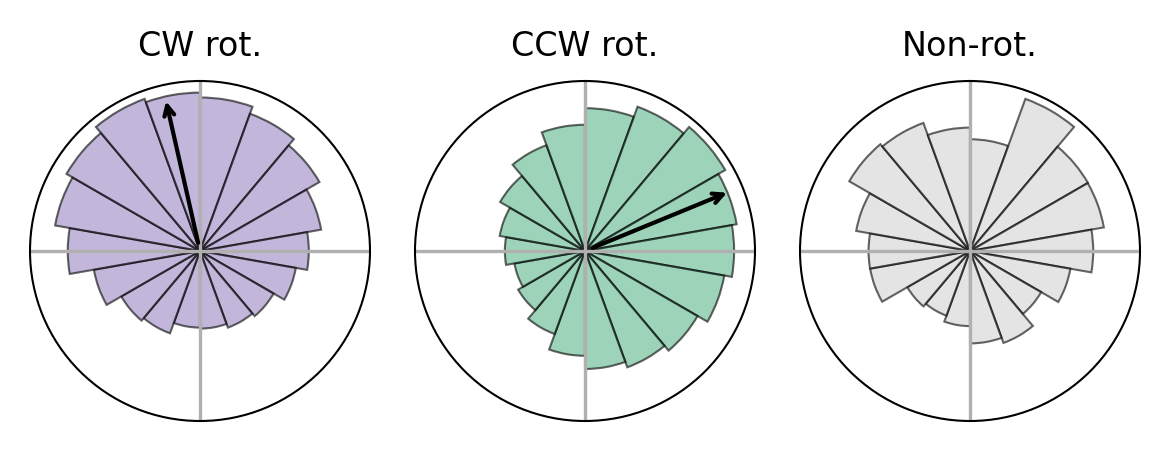

In [64]:
# Define the range of cell indices
start_idx = 20
end_idx = 30  # inclusive

# Define bins for relative angles from -π to π
num_bins = 18
angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2

#get relative angles to the goal
relative_angle = get_relativeDir2Goal(animal_head_loc_all_no_td, hd_all_no_td, rand_loc)
# relative_angle = get_relativeDir2Goal(Animal_center_all, Head_direction_all, goal_loc)

total_binned_activity_cw = np.zeros(num_bins)  
total_binned_activity_ccw = np.zeros(num_bins)  
total_binned_activity_ns = np.zeros(num_bins) 
 
# Loop through the specified submatrix of cells
for i in range(start_idx, end_idx + 1):
    for j in range(start_idx, end_idx + 1):
        pc_activity_ij = pc_activity_no_td[:, i, j]
        
        #cloclwise
        direction = 'clockwise'
        binned_activity = get_anticipatory(pc_activity_ij, relative_angle, rotation_direction_flag_all_no_td, 
                                           direction=direction, num_bins=num_bins, normalize_rate=normalize_rate)
        total_binned_activity_cw += binned_activity  # Accumulate the binned activity across all cells

        #counterclockwise
        direction = 'counter_clockwise'
        binned_activity = get_anticipatory(pc_activity_ij, relative_angle, rotation_direction_flag_all_no_td, 
                                           direction=direction, num_bins=num_bins, normalize_rate=normalize_rate)
        total_binned_activity_ccw += binned_activity  # Accumulate the binned activity across all cells
        
        # nonscanning
        direction = 'nonscanning'
        binned_activity = get_anticipatory(pc_activity_ij, relative_angle, rotation_direction_flag_all_no_td, 
                                           direction=direction, num_bins=num_bins, normalize_rate=normalize_rate)
        total_binned_activity_ns += binned_activity  # Accumulate the binned activity across all cells
        
# Convert bin centers to polar coordinates
theta = np.append(bin_centers, bin_centers[0])

total_binned_activity_cw = np.append(total_binned_activity_cw, total_binned_activity_cw[0])
total_binned_activity_ccw = np.append(total_binned_activity_ccw, total_binned_activity_ccw[0])
total_binned_activity_ns = np.append(total_binned_activity_ns, total_binned_activity_ns[0])

# Bar width based on bin size
bar_width = 2 * np.pi / num_bins

# Create polar plot with bars instead of line
fig, axs = plt.subplots(1, 3, subplot_kw={'projection': 'polar'}, figsize=(4, 2), dpi=300)

ax = axs[0]

bars = ax.bar(
    bin_centers,
    total_binned_activity_cw[:-1],  # exclude the repeated value
    width=bar_width,
    bottom=0.0,
    color='#9A88C2', #'#2167AC', #28A25F
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)
#set title
ax.set_title("CW rot.", fontsize=8)

#get the mean angle
mean_angle_cw = np.arctan2(
    np.sum(total_binned_activity_cw[:-1] * np.sin(bin_centers)),
    np.sum(total_binned_activity_cw[:-1] * np.cos(bin_centers))
)
mean_angle_cw_deg = np.rad2deg(mean_angle_cw) % 360

#add mean_angle_deg line as an arrow
mean_angle_cw_rad = np.deg2rad(mean_angle_cw_deg)

r_max_cw = np.max(total_binned_activity_cw[:-1])


ax.annotate('', xy=(mean_angle_cw_rad, r_max_cw), xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=1.0),
            fontsize=6, color='black', label=f'Mean Angle: {mean_angle_cw_deg:.1f}°')

ax = axs[1]
bars = ax.bar(
    bin_centers,
    total_binned_activity_ccw[:-1],  # exclude the repeated value
    width=bar_width,
    bottom=0.0,
    color='#5CB68A', #orange
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)
ax.set_title("CCW rot.", fontsize=8)

#get the mean angle
mean_angle_ccw = np.arctan2(
    np.sum(total_binned_activity_ccw[:-1] * np.sin(bin_centers)),
    np.sum(total_binned_activity_ccw[:-1] * np.cos(bin_centers))
)
mean_angle_ccw_deg = np.rad2deg(mean_angle_ccw) % 360
#add mean_angle_deg line as an arrow
mean_angle_ccw_rad = np.deg2rad(mean_angle_ccw_deg)
r_max_ccw = np.max(total_binned_activity_ccw[:-1])

ax.annotate('', xy=(mean_angle_ccw_rad, r_max_ccw), xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=1.0),
            fontsize=6, color='black', label=f'Mean Angle: {mean_angle_ccw_deg:.1f}°')


ax = axs[2]
bars = ax.bar(
    bin_centers,
    total_binned_activity_ns[:-1],  # exclude the repeated value
    width=bar_width,
    bottom=0.0,
    color='lightgrey',
    alpha=0.6,
    edgecolor='black',
    linewidth=0.5
)
ax.set_title("Non-rot.", fontsize=8)


for ax in axs:
    # Polar aesthetics
    ax.set_theta_zero_location('N')  # 0 at top
    ax.set_theta_direction(-1)       # clockwise
    #only show 0, 90, 180, 270
    ax.set_xticks([0, np.pi/2, np.pi, 3*np.pi/2])
    # ax.set_xticklabels(['0', '90', '180', '270'])
    ax.set_xticklabels(['', '', '', ''])
    #remove y ticks
    ax.set_yticks([])
    #xtick fontsize as 6
    ax.tick_params(labelsize=6)
    ax.xaxis.set_tick_params(pad=-4) 
    #axis width 0.5
    ax.spines['polar'].set_linewidth(0.5)
    #ticks off  

plt.tight_layout()

# plt.savefig('figures/PaperFig/anticipatory_Allcell.pdf', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

In [93]:
relative_angle_random_locs_cw = []
relative_angle_random_locs_ccw = []
relative_angle_random_locs_ns = []

from tqdm import trange

for i in trange(50):
    rand_loc = np.random.uniform(-np.pi, np.pi, (2, ))

    # Define the range of cell indices
    start_idx = 20
    end_idx = 30  # inclusive

    # Define bins for relative angles from -π to π
    num_bins = 18
    angle_bins = np.linspace(-np.pi, np.pi, num_bins + 1)
    bin_centers = (angle_bins[:-1] + angle_bins[1:]) / 2

    #get relative angles to the goal
    relative_angle = get_relativeDir2Goal(animal_head_loc_all_no_td, hd_all_no_td, rand_loc)
    
    total_binned_activity_cw = np.zeros(num_bins)  
    total_binned_activity_ccw = np.zeros(num_bins)  
    total_binned_activity_ns = np.zeros(num_bins) 
    
    # Loop through the specified submatrix of cells
    for i in range(start_idx, end_idx + 1):
        for j in range(start_idx, end_idx + 1):
            pc_activity_ij = pc_activity_no_td[:, i, j]
            
            #cloclwise
            direction = 'clockwise'
            binned_activity = get_anticipatory(pc_activity_ij, relative_angle, rotation_direction_flag_all_no_td, 
                                            direction=direction, num_bins=num_bins, normalize_rate=normalize_rate)
            total_binned_activity_cw += binned_activity  # Accumulate the binned activity across all cells

            #counterclockwise
            direction = 'counter_clockwise'
            binned_activity = get_anticipatory(pc_activity_ij, relative_angle, rotation_direction_flag_all_no_td, 
                                            direction=direction, num_bins=num_bins, normalize_rate=normalize_rate)
            total_binned_activity_ccw += binned_activity  # Accumulate the binned activity across all cells
            
            # nonscanning
            direction = 'nonscanning'
            binned_activity = get_anticipatory(pc_activity_ij, relative_angle, rotation_direction_flag_all_no_td, 
                                            direction=direction, num_bins=num_bins, normalize_rate=normalize_rate)
            total_binned_activity_ns += binned_activity  # Accumulate the binned activity across all cells
            
    # Convert bin centers to polar coordinates
    theta = np.append(bin_centers, bin_centers[0])

    total_binned_activity_cw = np.append(total_binned_activity_cw, total_binned_activity_cw[0])
    total_binned_activity_ccw = np.append(total_binned_activity_ccw, total_binned_activity_ccw[0])
    total_binned_activity_ns = np.append(total_binned_activity_ns, total_binned_activity_ns[0])

    # Bar width based on bin size
    bar_width = 2 * np.pi / num_bins
    
    relative_angle_random_locs_cw.append(total_binned_activity_cw[:-1])  # exclude the repeated value
    relative_angle_random_locs_ccw.append(total_binned_activity_ccw[:-1])  # exclude the repeated value
    relative_angle_random_locs_ns.append(total_binned_activity_ns[:-1])  # exclude the repeated value
        

relative_angle_random_locs_cw = np.array(relative_angle_random_locs_cw).sum(0)
relative_angle_random_locs_ccw = np.array(relative_angle_random_locs_ccw).sum(0)
relative_angle_random_locs_ns = np.array(relative_angle_random_locs_ns).sum(0)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [01:46<00:00,  2.13s/it]


In [78]:
relative_angle_random_locs_cw.shape

(18,)

315.0635425018935 45.64740281355683


/Users/changminyu/Desktop/research/codes/neuroscience/HoneycombSweeps/plotting_utils.py:245: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', '', '', '', '', '', '', ''], fontsize=fontsize)
/Users/changminyu/Desktop/research/codes/neuroscience/HoneycombSweeps/plotting_utils.py:245: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', '', '', '', '', '', '', ''], fontsize=fontsize)


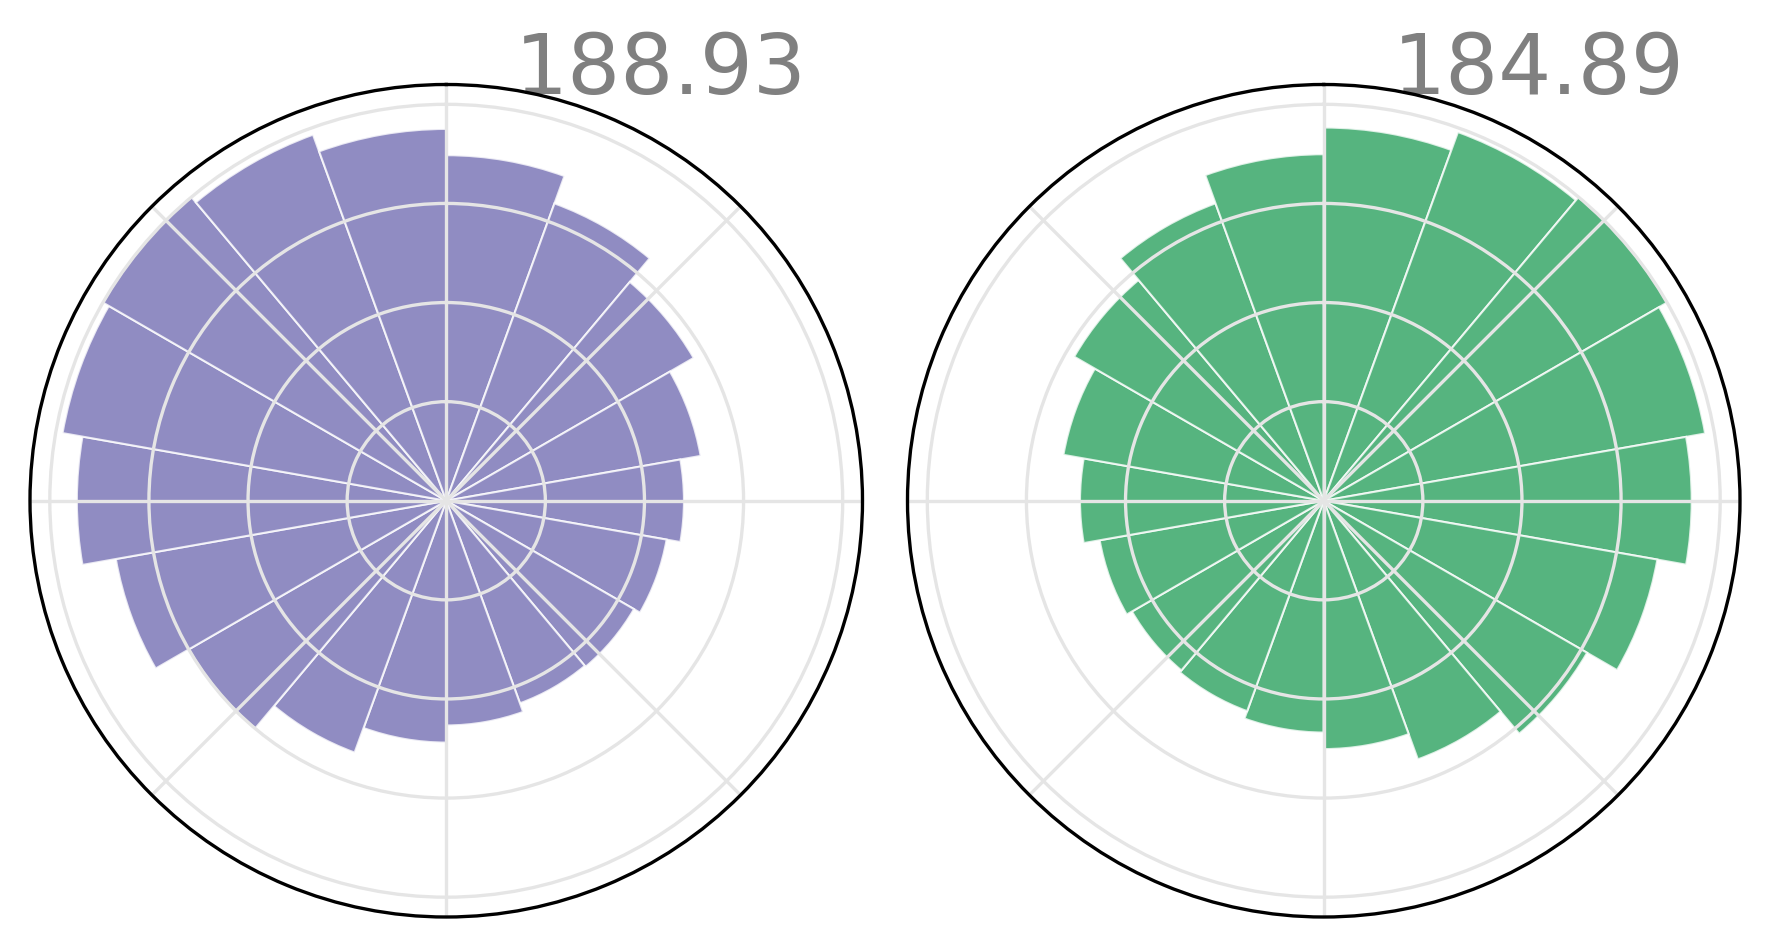

In [91]:
fig, ax = plt.subplots(1, 2, figsize=(6, 3.8), dpi=300, subplot_kw={'projection': 'polar'})

bins = np.linspace(-np.pi, np.pi, 19)

cw_colors = {
    'bars': '#7570B3',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',          # Nearly black for clear text
}
ccw_colors = {
    'bars': '#2CA25F',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',          # Nearly black for clear text
}
ns_colors = {
    'bars': '#111111',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',
}

plot_circular_histogram_with_values(
    fig=fig, 
    ax=ax[0], 
    counts=relative_angle_random_locs_cw/50, 
    bins=bins, 
    fontsize=20, 
    colors=cw_colors, 
    show_dir_bins=False, 
)

plot_circular_histogram_with_values(
    fig=fig, 
    ax=ax[1], 
    counts=relative_angle_random_locs_ccw/50, 
    bins=bins, 
    fontsize=20, 
    colors=ccw_colors,
    show_dir_bins=False, 
)

# plot_circular_histogram_with_values(
#     fig=fig, 
#     ax=ax[2], 
#     counts=relative_angle_random_locs_ns, 
#     bins=bins, 
#     fontsize=20, 
#     colors=ns_colors,
#     alpha=0.5, 
#     show_dir_bins=False, 
# )

#get the CW mean angle
mean_angle_cw = np.arctan2(
    np.sum(relative_angle_random_locs_cw * np.sin(bin_centers)),
    np.sum(relative_angle_random_locs_cw * np.cos(bin_centers))
)
mean_angle_cw_deg = np.rad2deg(mean_angle_cw) % 360

#add mean_angle_deg line as an arrow
mean_angle_cw_rad = np.deg2rad(mean_angle_cw_deg)

r_max_cw = np.max(relative_angle_random_locs_cw)


ax[0].annotate('', xy=(mean_angle_cw_rad, r_max_cw), xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=4.0),
            fontsize=6, color='black', label=f'Mean Angle: {mean_angle_cw_deg:.1f}°')

#get the CCW mean angle
mean_angle_ccw = np.arctan2(
    np.sum(relative_angle_random_locs_ccw * np.sin(bin_centers)),
    np.sum(relative_angle_random_locs_ccw * np.cos(bin_centers))
)
mean_angle_ccw_deg = np.rad2deg(mean_angle_ccw) % 360
#add mean_angle_deg line as an arrow
mean_angle_ccw_rad = np.deg2rad(mean_angle_ccw_deg)
r_max_ccw = np.max(relative_angle_random_locs_ccw)

ax[1].annotate('', xy=(mean_angle_ccw_rad, r_max_ccw), xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=4.0),
            fontsize=6, color='black', label=f'Mean Angle: {mean_angle_ccw_deg:.1f}°')

print(mean_angle_cw_deg, mean_angle_ccw_deg)

# ax[0].set_title("CW", fontsize=20, pad=20)
# ax[1].set_title("CCW", fontsize=20, pad=20)
# ax[2].set_title("Non-Rot.", fontsize=20, pad=20)

plt.tight_layout()

fig.savefig('figures/PaperFig/anticipatory_Allcell_mean_firing_angles_random_loc_no_td.pdf', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

In [94]:
(relative_angle_random_locs_cw_with_td, relative_angle_random_locs_ccw_with_td, relative_angle_random_locs_ns_with_td) = pickle.load(
    open('logs/anticipatory_population_firing_rate_random_loc_with_td.pkl', 'rb'
))

/Users/changminyu/Desktop/research/codes/neuroscience/HoneycombSweeps/plotting_utils.py:245: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', '', '', '', '', '', '', ''], fontsize=fontsize)
/Users/changminyu/Desktop/research/codes/neuroscience/HoneycombSweeps/plotting_utils.py:245: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', '', '', '', '', '', '', ''], fontsize=fontsize)
/Users/changminyu/Desktop/research/codes/neuroscience/HoneycombSweeps/plotting_utils.py:245: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['', '', '', '', '', '', '', ''], fontsize=fontsize)
/Users/changminyu/Desktop/research/codes/neuroscience/HoneycombSweeps/plotting_utils.py:245: UserWarning: set_tickl

320.23942542772613 48.274764572448554
354.6714726325413 2.9359960059079286


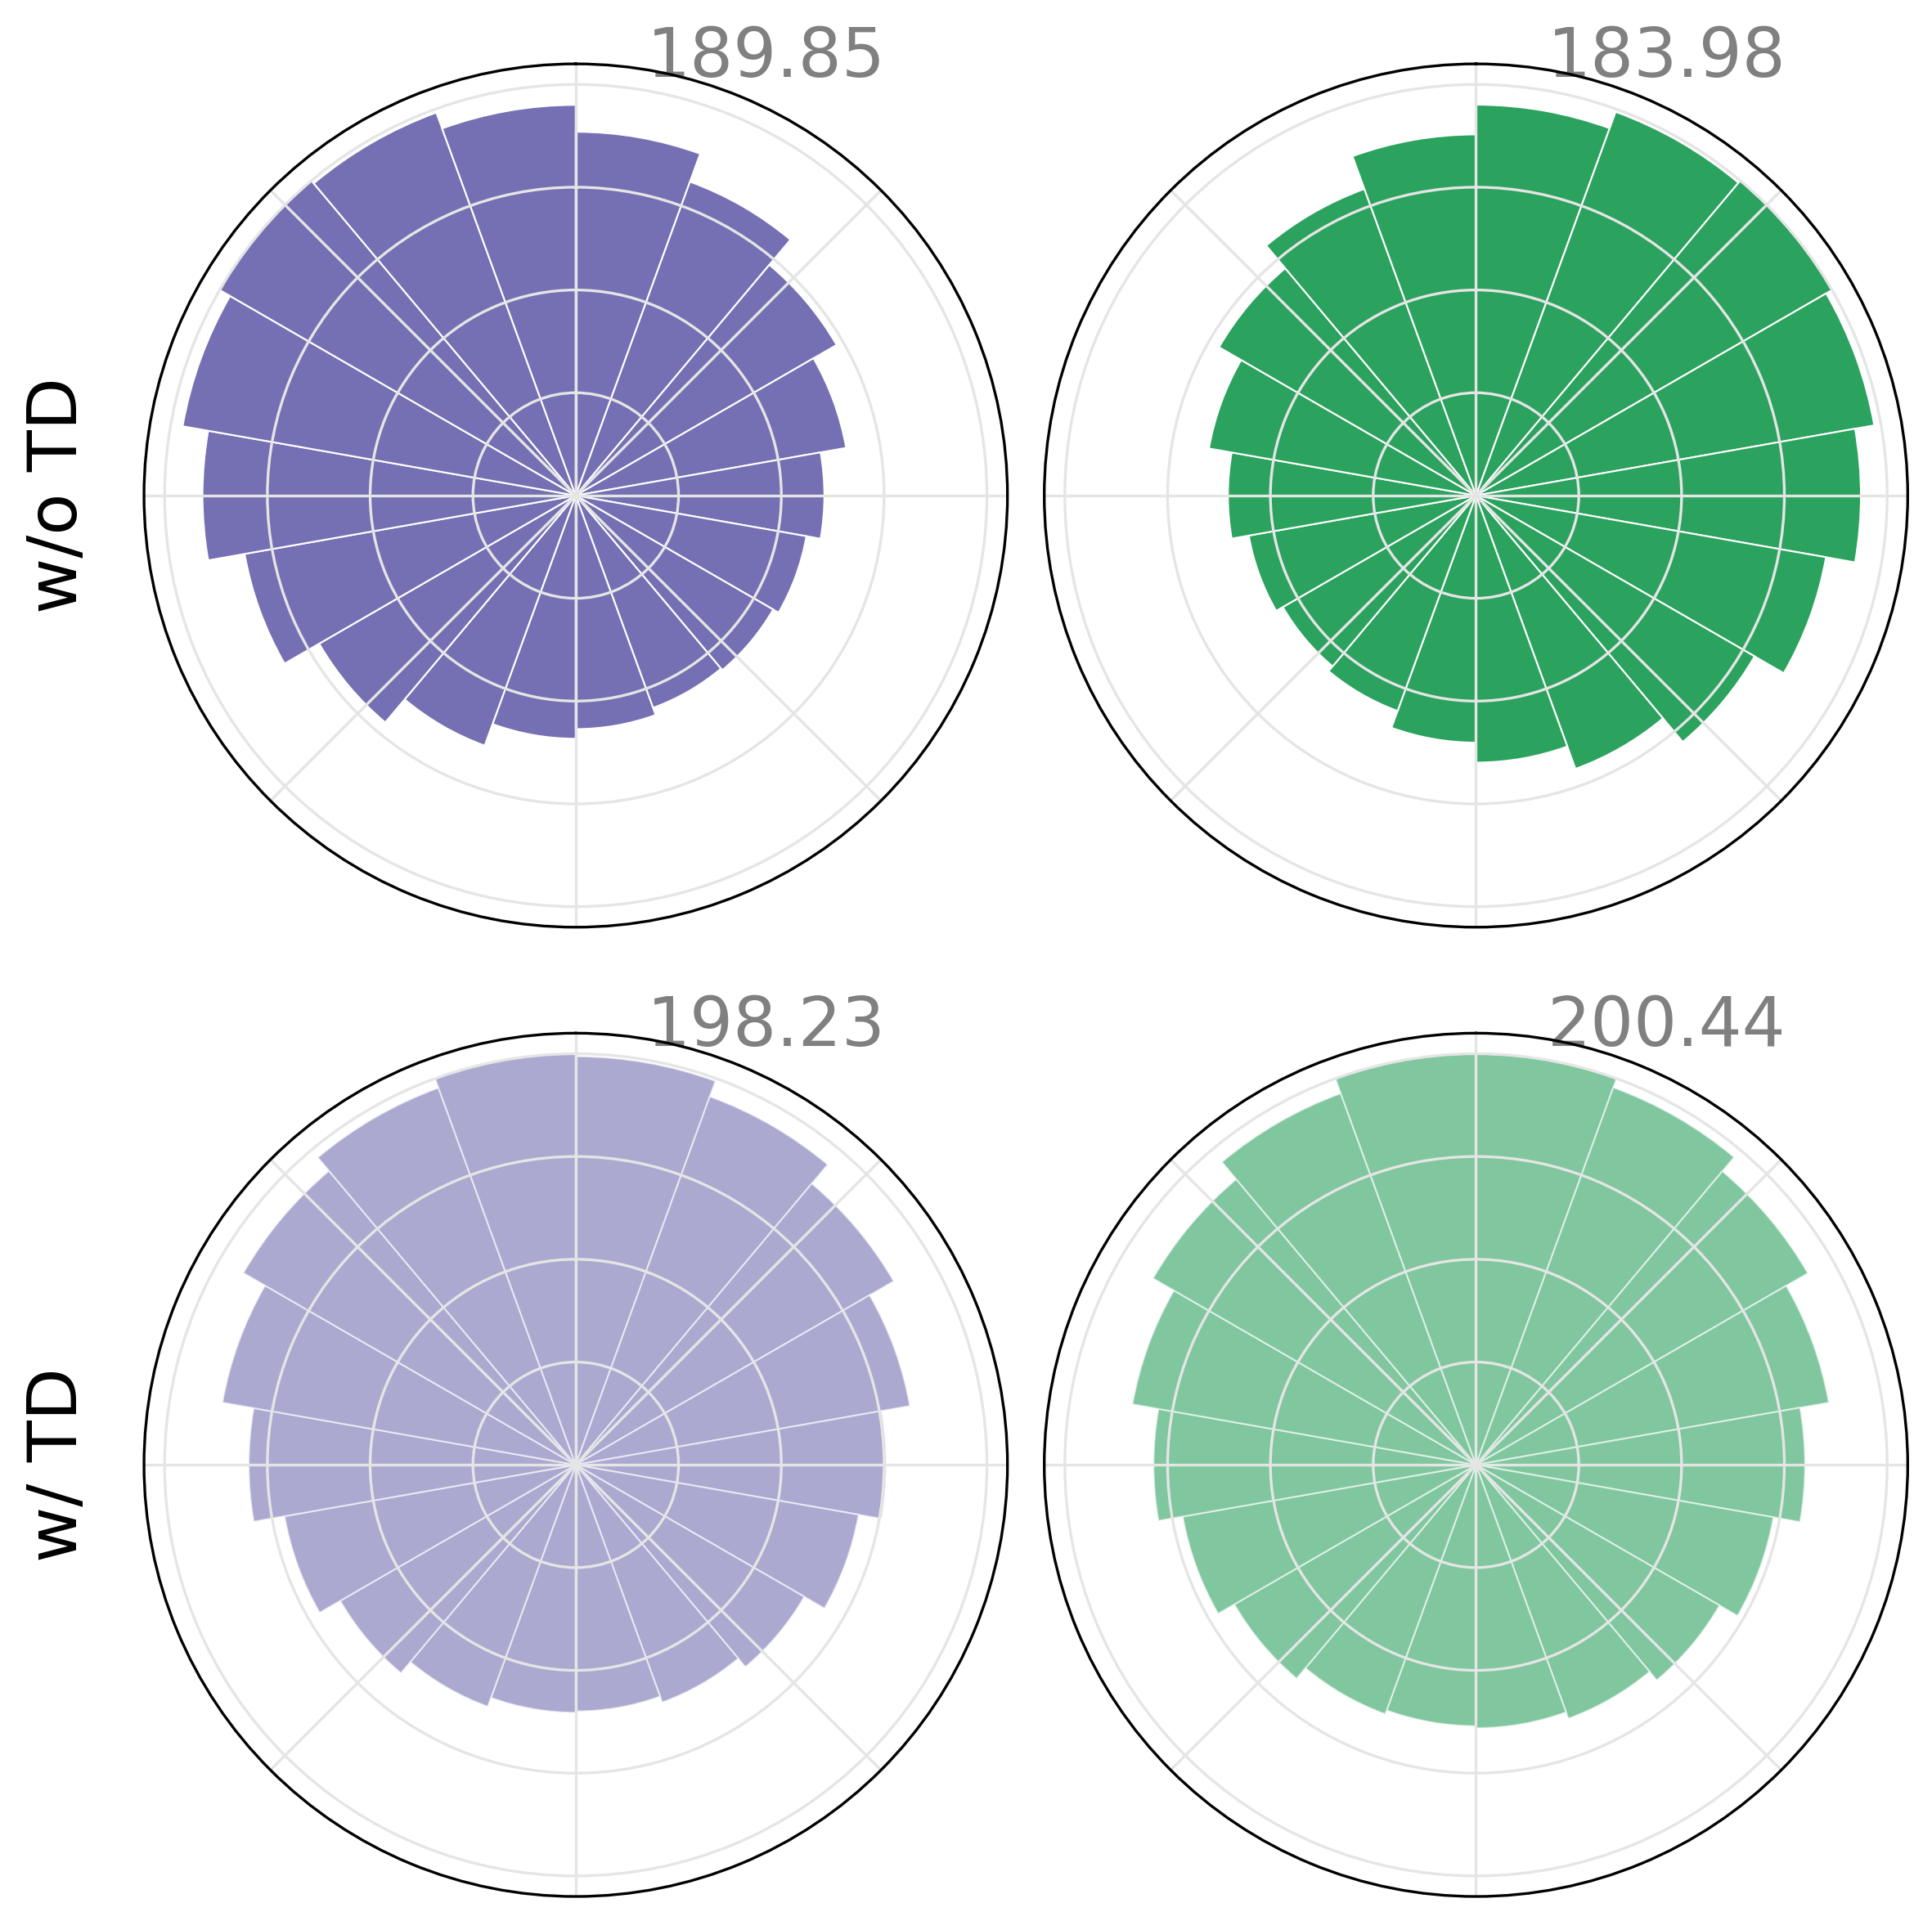

In [106]:
fig, ax = plt.subplots(2, 2, figsize=(8, 10), dpi=300, subplot_kw={'projection': 'polar'})

bins = np.linspace(-np.pi, np.pi, 19)

cw_colors = {
    'bars': '#7570B3',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',          # Nearly black for clear text
}
ccw_colors = {
    'bars': '#2CA25F',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',          # Nearly black for clear text
}
ns_colors = {
    'bars': '#111111',          # Sophisticated burgundy - professional but engaging
    'edge': '#662B49',          # Slightly darker edge for definition  
    'grid': '#E5E5E5',          # Very light gray for subtle gridlines
    'text': 'gray',
}

plot_circular_histogram_with_values(
    fig=fig, 
    ax=ax[0, 0], 
    counts=relative_angle_random_locs_cw/50, 
    bins=bins, 
    fontsize=20, 
    colors=cw_colors, 
    show_dir_bins=False, 
    alpha=1.0, 
)

plot_circular_histogram_with_values(
    fig=fig, 
    ax=ax[0, 1], 
    counts=relative_angle_random_locs_ccw/50, 
    bins=bins, 
    fontsize=20, 
    colors=ccw_colors,
    show_dir_bins=False, 
    alpha=1.0, 
)

plot_circular_histogram_with_values(
    fig=fig, 
    ax=ax[1, 0], 
    counts=relative_angle_random_locs_cw_with_td/50, 
    bins=bins, 
    fontsize=20, 
    colors=cw_colors, 
    show_dir_bins=False, 
    alpha=0.6, 
)

plot_circular_histogram_with_values(
    fig=fig, 
    ax=ax[1, 1], 
    counts=relative_angle_random_locs_ccw_with_td/50, 
    bins=bins, 
    fontsize=20, 
    colors=ccw_colors,
    show_dir_bins=False, 
    alpha=0.6, 
)

# plot_circular_histogram_with_values(
#     fig=fig, 
#     ax=ax[2], 
#     counts=relative_angle_random_locs_ns, 
#     bins=bins, 
#     fontsize=20, 
#     colors=ns_colors,
#     alpha=0.5, 
#     show_dir_bins=False, 
# )

#get the CW mean angle
mean_angle_cw = np.arctan2(
    np.sum(relative_angle_random_locs_cw * np.sin(bin_centers)),
    np.sum(relative_angle_random_locs_cw * np.cos(bin_centers))
)
mean_angle_cw_deg = np.rad2deg(mean_angle_cw) % 360

#add mean_angle_deg line as an arrow
mean_angle_cw_rad = np.deg2rad(mean_angle_cw_deg)

r_max_cw = np.max(relative_angle_random_locs_cw)


ax[0, 0].annotate('', xy=(mean_angle_cw_rad, r_max_cw), xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=4.0),
            fontsize=6, color='black', label=f'Mean Angle: {mean_angle_cw_deg:.1f}°')

#get the CCW mean angle
mean_angle_ccw = np.arctan2(
    np.sum(relative_angle_random_locs_ccw * np.sin(bin_centers)),
    np.sum(relative_angle_random_locs_ccw * np.cos(bin_centers))
)
mean_angle_ccw_deg = np.rad2deg(mean_angle_ccw) % 360
#add mean_angle_deg line as an arrow
mean_angle_ccw_rad = np.deg2rad(mean_angle_ccw_deg)
r_max_ccw = np.max(relative_angle_random_locs_ccw)

ax[0, 1].annotate('', xy=(mean_angle_ccw_rad, r_max_ccw), xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=4.0),
            fontsize=6, color='black', label=f'Mean Angle: {mean_angle_ccw_deg:.1f}°')

print(mean_angle_cw_deg, mean_angle_ccw_deg)

#get the CW mean angle
mean_angle_cw = np.arctan2(
    np.sum(relative_angle_random_locs_cw_with_td * np.sin(bin_centers)),
    np.sum(relative_angle_random_locs_cw_with_td * np.cos(bin_centers))
)
mean_angle_cw_deg = np.rad2deg(mean_angle_cw) % 360

#add mean_angle_deg line as an arrow
mean_angle_cw_rad = np.deg2rad(mean_angle_cw_deg)

r_max_cw = np.max(relative_angle_random_locs_cw_with_td)


ax[1, 0].annotate('', xy=(mean_angle_cw_rad, r_max_cw), xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=4.0),
            fontsize=6, color='black', label=f'Mean Angle: {mean_angle_cw_deg:.1f}°')

#get the CCW mean angle
mean_angle_ccw = np.arctan2(
    np.sum(relative_angle_random_locs_ccw_with_td * np.sin(bin_centers)),
    np.sum(relative_angle_random_locs_ccw_with_td * np.cos(bin_centers))
)
mean_angle_ccw_deg = np.rad2deg(mean_angle_ccw) % 360
#add mean_angle_deg line as an arrow
mean_angle_ccw_rad = np.deg2rad(mean_angle_ccw_deg)
r_max_ccw = np.max(relative_angle_random_locs_ccw_with_td)

ax[0, 1].annotate('', xy=(mean_angle_ccw_rad, r_max_ccw), xytext=(0, 0),
            arrowprops=dict(arrowstyle='->', color='black', linewidth=4.0),
            fontsize=6, color='black', label=f'Mean Angle: {mean_angle_ccw_deg:.1f}°')

print(mean_angle_cw_deg, mean_angle_ccw_deg)

# ax[0].set_title("CW", fontsize=20, pad=20)
# ax[1].set_title("CCW", fontsize=20, pad=20)
# ax[2].set_title("Non-Rot.", fontsize=20, pad=20)

ax[0, 0].text(-.1, 0.5, "w/o TD", fontsize=20, ha='center', va='center', transform=ax[0, 0].transAxes, rotation=90)
ax[1, 0].text(-.1, 0.5, "w/ TD", fontsize=20, ha='center', va='center', transform=ax[1, 0].transAxes, rotation=90)

plt.tight_layout()

fig.savefig('figures/PaperFig/anticipatory_Allcell_mean_firing_angles_random_loc_with_and_no_td.pdf', bbox_inches='tight', dpi=300, transparent=True)

plt.show()